# Import  

In [2]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
#import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, pearsonr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

# Parameter Initialize

In [3]:
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

act_directory = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/Notebooks/Analysis_Cache'
#ops_directory = 'C:\\Users\insan\\Desktop\\Opsin_Cache'
beh_directory = '/Users/insanallylab/Desktop/Behavioor'

#opsin
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']
all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#Ephy
ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

# Behavior

In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

/Users/insanallylab/Desktop/EphysAnalysis/Notebooks/SB/../../InsanallyLabEphysTools/behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite valu

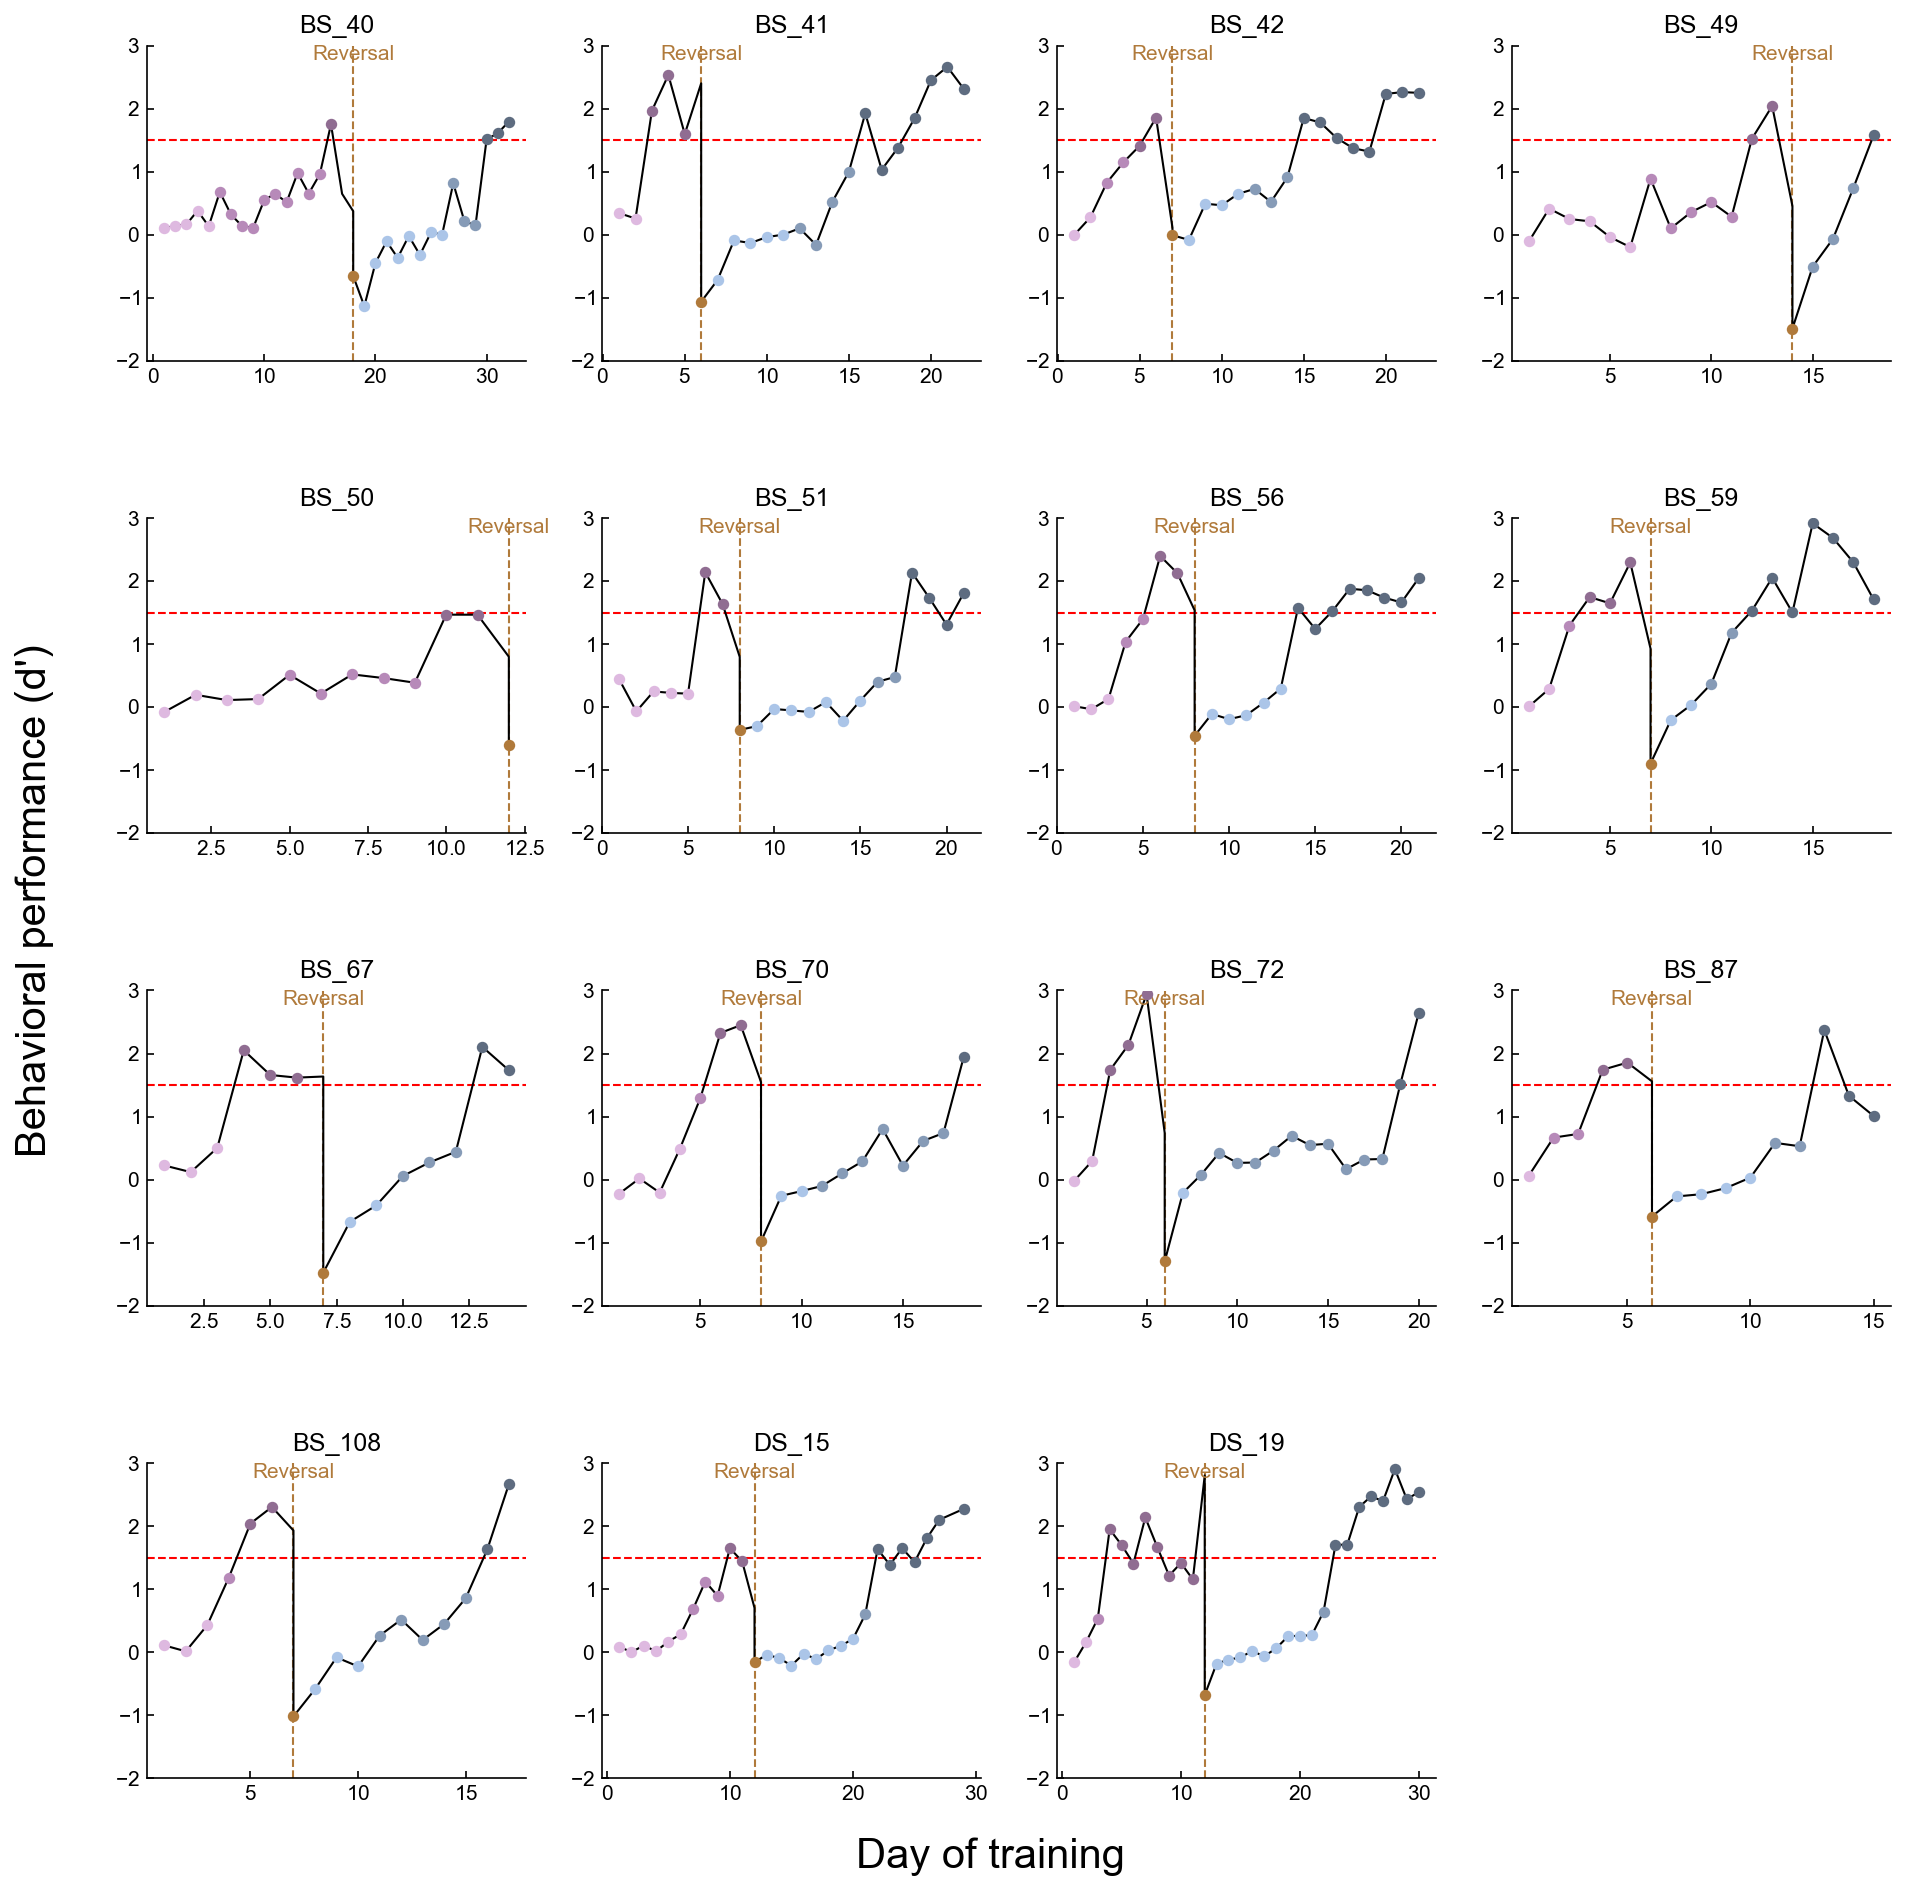

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(ephys_animals,animalBehaviors,plot=True)

# Session files

In [6]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in ephys_animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass

        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|█████████████████████████████████████████| 255/255 [00:25<00:00,  9.97it/s]

AC       : 1832
M2       : 1628


In [7]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|███████████████████████████████████████| 1628/1628 [00:32<00:00, 50.21it/s]

errors for: []


In [8]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|███████████████████████████████████████| 1832/1832 [00:50<00:00, 36.36it/s]

errors for: []


# Learning Stages

In [9]:
preearly_animals_M2 = []
prelate_animals_M2  = []
preexpert_animals_M2  = []
postearly_animals_M2  = []
postlate_animals_M2  = []
postexpert_animals_M2  = []

FRmod_preearly_M2 = []
FRmod_prelate_M2 = []
FRmod_preexpert_M2 = []
FRmod_postearly_M2 = []
FRmod_postlate_M2 = []
FRmod_postexpert_M2 = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILM2phases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if EILM2phases[idx] == 'pre early':
        FRmod_preearly_M2.append(FRmod)
        preearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'pre late':
        FRmod_prelate_M2.append(FRmod)
        prelate_animals_M2.append(sessionfile.meta.animal)  
        
    elif EILM2phases[idx] == 'pre expert':
        FRmod_preexpert_M2.append(FRmod)
        preexpert_animals_M2.append(sessionfile.meta.animal)     
        
    elif EILM2phases[idx] == 'post early':
        FRmod_postearly_M2.append(FRmod)
        postearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'post late':
        FRmod_postlate_M2.append(FRmod)
        postlate_animals_M2.append(sessionfile.meta.animal)    
        
    elif EILM2phases[idx] == 'post expert':
        FRmod_postexpert_M2.append(FRmod)
        postexpert_animals_M2.append(sessionfile.meta.animal)

FRmod_preearly_M2 = np.array(FRmod_preearly_M2)
FRmod_prelate_M2 = np.array(FRmod_prelate_M2)
FRmod_preexpert_M2 = np.array(FRmod_preexpert_M2)
FRmod_postearly_M2 = np.array(FRmod_postearly_M2)
FRmod_postlate_M2 = np.array(FRmod_postlate_M2)
FRmod_postexpert_M2 = np.array(FRmod_postexpert_M2)

1628it [00:38, 42.84it/s]


In [10]:
preearly_animals_AC = []
prelate_animals_AC  = []
preexpert_animals_AC  = []
postearly_animals_AC  = []
postlate_animals_AC  = []
postexpert_animals_AC  = []

FRmod_preearly_AC = []
FRmod_prelate_AC = []
FRmod_preexpert_AC = []
FRmod_postearly_AC = []
FRmod_postlate_AC = []
FRmod_postexpert_AC = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILACphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if EILACphases[idx] == 'pre early':
        FRmod_preearly_AC.append(FRmod)
        preearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'pre late':
        FRmod_prelate_AC.append(FRmod)
        prelate_animals_AC.append(sessionfile.meta.animal)  
        
    elif EILACphases[idx] == 'pre expert':
        FRmod_preexpert_AC.append(FRmod)
        preexpert_animals_AC.append(sessionfile.meta.animal)     
        
    elif EILACphases[idx] == 'post early':
        FRmod_postearly_AC.append(FRmod)
        postearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'post late':
        FRmod_postlate_AC.append(FRmod)
        postlate_animals_AC.append(sessionfile.meta.animal)    
        
    elif EILACphases[idx] == 'post expert':
        FRmod_postexpert_AC.append(FRmod)
        postexpert_animals_AC.append(sessionfile.meta.animal)

FRmod_preearly_AC = np.array(FRmod_preearly_AC)
FRmod_prelate_AC = np.array(FRmod_prelate_AC)
FRmod_preexpert_AC = np.array(FRmod_preexpert_AC)
FRmod_postearly_AC = np.array(FRmod_postearly_AC)
FRmod_postlate_AC = np.array(FRmod_postlate_AC)
FRmod_postexpert_AC = np.array(FRmod_postexpert_AC)

124it [00:04, 42.30it/s]

1
4
6
8
17
19
22
31
32
42
47
48
60


521it [00:16, 51.71it/s]

9
11
12
20
25
34
41
42
60
65
67
69
70
79
80
84
86
93
98
99
102
105
111
112
113


1832it [00:51, 35.53it/s]


In [11]:
preearly_animals_M2 = np.unique(preearly_animals_M2)
prelate_animals_M2 = np.unique(prelate_animals_M2)
preexpert_animals_M2 = np.unique(preexpert_animals_M2)
postearly_animals_M2 = np.unique(postearly_animals_M2)
postlate_animals_M2 = np.unique(postlate_animals_M2)
postexpert_animals_M2 = np.unique(postexpert_animals_M2)

preearly_animals_AC = np.unique(preearly_animals_AC)
prelate_animals_AC = np.unique(prelate_animals_AC)
preexpert_animals_AC = np.unique(preexpert_animals_AC)
postearly_animals_AC = np.unique(postearly_animals_AC)
postlate_animals_AC = np.unique(postlate_animals_AC)
postexpert_animals_AC = np.unique(postexpert_animals_AC)

print('M2 Animals')
print(preearly_animals_M2)
print(prelate_animals_M2)
print(preexpert_animals_M2)
print(postearly_animals_M2)
print(postlate_animals_M2)
print(postexpert_animals_M2)
print('AC Animals')
print(preearly_animals_AC)
print(prelate_animals_AC)
print(preexpert_animals_AC)
print(postearly_animals_AC)
print(postlate_animals_AC)
print(postexpert_animals_AC)

M2 Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_50' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_41' 'BS_42' 'BS_51' 'BS_56' 'BS_59' 'BS_67' 'BS_87']
AC Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_40' 'BS_49' 'BS_72' 'BS_87' 'DS_15' 'DS_19']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_51' 'BS_56' 'BS_67' 'BS_70' 'BS_87'
 'DS_15' 'DS_19']


In [12]:
AC_sessions = np.unique(EnumACSession)
M2_sessions = np.unique(EnumM2Session)

In [13]:
ACphases = np.full_like(AC_sessions,np.nan)
error_animals = []

AC_switch = []
AC_preearly = []
AC_prelate = []
AC_preexpert = []
AC_postearly = []
AC_postlate = []
AC_postexpert = []

for idx,session in enumerate(tqdm(AC_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            ACphases[idx] = 'switch'
            AC_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            ACphases[idx] = 'pre early'
            AC_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            ACphases[idx] = 'pre late'
            AC_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            ACphases[idx] = 'pre expert'
            AC_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            ACphases[idx] = 'post early'
            AC_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            ACphases[idx] = 'post late'
            AC_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            ACphases[idx] = 'post expert'
            AC_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

print(len(ACphases))
print(len(AC_preearly))
print(len(AC_prelate))
print(len(AC_preexpert))
print(len(AC_postearly))
print(len(AC_postlate))
print(len(AC_postexpert))
print(len(AC_switch))

100%|█████████████████████████████████████████| 132/132 [00:01<00:00, 77.14it/s]

errors for: []
132
6
14
10
36
26
31
8


In [14]:
M2phases = np.full_like(M2_sessions,np.nan)
error_animals = []

M2_switch = []
M2_preearly = []
M2_prelate = []
M2_preexpert = []
M2_postearly = []
M2_postlate = []
M2_postexpert = []

for idx,session in enumerate(tqdm(M2_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            M2phases[idx] = 'switch'
            M2_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            M2phases[idx] = 'pre early'
            M2_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            M2phases[idx] = 'pre late'
            M2_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            M2phases[idx] = 'pre expert'
            M2_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            M2phases[idx] = 'post early'
            M2_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            M2phases[idx] = 'post late'
            M2_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            M2phases[idx] = 'post expert'
            M2_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

print(len(M2phases))
print(len(M2_preearly))
print(len(M2_prelate))
print(len(M2_preexpert))
print(len(M2_postearly))
print(len(M2_postlate))
print(len(M2_postexpert))
print(len(M2_switch))

100%|█████████████████████████████████████████| 103/103 [00:07<00:00, 13.85it/s]

errors for: []
103
7
13
10
19
24
19
9


In [15]:
#Obtaining corresponding M2 session name

# for ac_name in EnumACSession:
#     m2_name = ac_name.replace('AC', 'M2')

## Finding the intersection of recordings in AC and M2

In [18]:
for recording in AC_preearly:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_preearly:
        AC_preearly.remove(recording)

In [46]:
for recording in AC_prelate:
    m2_name = recording.replace('AC', 'M2')
    h = m2_name in M2_prelate
    if m2_name not in M2_prelate:
        AC_prelate.remove(recording)

In [47]:
for recording in AC_preexpert:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_preexpert:
        AC_preexpert.remove(recording)

In [48]:
for recording in AC_postearly:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_postearly:
        AC_postearly.remove(recording)

In [49]:
for recording in AC_postlate:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_postlate:
        AC_postlate.remove(recording)

In [50]:
for recording in AC_postexpert:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_postexpert:
        AC_postexpert.remove(recording)

# Correlation Analysis

In [51]:
# Function to obtain pairs of AC and M2 sessions and cluster

def getPairsACM2_AndClustersPairs(AC_session):
    session_AC = ilep.loadSessionCached(act_directory,AC_session)
    m2_name = AC_session.replace('AC','M2')
    index_M2 = EnumM2Session.index(m2_name)
    session_M2 = ilep.loadSessionCached(act_directory,EnumM2Session[index_M2])
    clust_AC = session_AC.clusters.good
    clust_M2 = session_M2.clusters.good
    cluster_pairs = list(product(clust_AC, clust_M2))
    return session_AC,session_M2, clust_AC, clust_M2, cluster_pairs

In [52]:
def getTrialstoUse(session_AC, session_M2, clustAC, clustM2):
    trials_AC = ilep.getAllConditions(session_AC,clustAC,trialsPerDayLoaded=None)['all_trials']
    trials_M2 = ilep.getAllConditions(session_M2,clustM2,trialsPerDayLoaded=None)['all_trials']
    trials_AC = trials_AC.trials
    trials_M2 = trials_M2.trials
    trials_to_use = np.intersect1d(trials_AC,trials_M2)
    return trials_to_use

In [53]:
# for session in AC_preearly:
#     session_AC = ilep.loadSessionCached(act_directory,session)
#     m2_name = session.replace('AC', 'M2')
#     index_m2 = EnumM2Session.index(m2_name)
#     session_m2 = ilep.loadSessionCached(act_directory,EnumM2Session[index_m2])
#     clust_AC = session_AC.clusters.good
#     clust_M2 = session_M2.clusers.good
    
#     for cluster in clust_AC:
#         trials_AC = ilep.getAllConditions(session_AC, cluster, trialsPerDayLoaded=None)['all_trials']
#         trial_AC = trials_AC.trials
#         all_trials_AC.append(trials_AC)
        

In [54]:
def getResSpikeCounts(trials_to_use, session_AC,session_M2, clust_AC, clust_M2, window):
    start_trials = session_AC.trials.starts
    start_trials = [start_trials[trial_id] for trial_id in trials_to_use]
    spikeTimes_AC = [[]]
    spikeTimes_M2 = [[]]
    for trials in start_trials:
        end_time = trials + window*30000
        spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=clust_AC,starttime=trials,endtime=end_time,cachedtimes=None)
        spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=clust_M2,starttime=trials,endtime=end_time,cachedtimes=None)
        spikeTimes_AC.append(spikeTimes_1_AC)
        spikeTimes_M2.append(spikeTimes_1_M2)

    spikeCountsAC = []
    spikeCountsM2 = []
    spikeCountsAC = [len(row) for row in spikeTimes_AC]
    spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
    spikeCountsAC = np.array(spikeCountsAC)
    spikeCountsM2 = np.array(spikeCountsM2)
    mean_AC = np.mean(spikeCountsAC)
    mean_M2 = np.mean(spikeCountsM2)
    resSpikeCountAC = spikeCountsAC - mean_AC
    resSpikeCountM2 = spikeCountsM2 - mean_M2
    
    return resSpikeCountAC, resSpikeCountM2
    

In [55]:
def getACM2PearsonCorrelation(AC_session):
    correlation = []
    p_value = []
    session_AC, session_M2, clust_AC, clust_M2, cluster_pairs = getPairsACM2_AndClustersPairs(AC_session)
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        trials_to_use = getTrialstoUse(session_AC, session_M2, AC_clust, M2_clust)
        if len(trials_to_use) >= 100:
            resSpikeCountAC, resSpikeCountM2 = getResSpikeCounts(trials_to_use, session_AC, session_M2, AC_clust, M2_clust, 0.2)
            corr, p_val = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            p_value.append(p_val)

    return correlation, p_value
            

# ALL TRIALS

In [157]:
preearly_corr = []

for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelation(session)
    preearly_corr.extend(correlation)

In [57]:
prelate_corr = []
for session in AC_prelate:
    correlation_pl, pval_pl = getACM2PearsonCorrelation(session)
    prelate_corr.extend(correlation_pl)

In [58]:
preexpert_corr = []
for session in AC_preexpert:
    correlation_pe, pval_pe = getACM2PearsonCorrelation(session)
    preexpert_corr.extend(correlation_pe)

In [59]:
postearly_corr = []
for session in AC_postearly:
    correlation_poe, pval_poe = getACM2PearsonCorrelation(session)
    postearly_corr.extend(correlation_poe)

In [60]:
postlate_corr = []
for session in AC_postlate:
    correlation_pol, pval_pol = getACM2PearsonCorrelation(session)
    postlate_corr.extend(correlation_pol)

In [61]:
postexpert_corr = []
for session in AC_postexpert:
    correlation_poex, pval_poex = getACM2PearsonCorrelation(session)
    postexpert_corr.extend(correlation_poex)

In [63]:
len(postearly_corr)

6168

## Histograms

### Pre-reversal

Text(0.5, 1.0, 'Pre-expert')

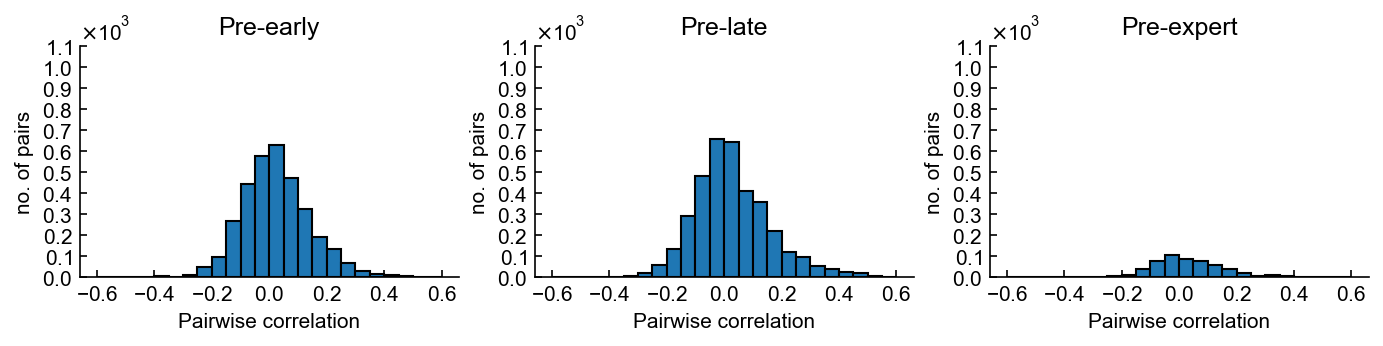

In [64]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
num_bins = 24

ax1.hist(preearly_corr,bins=num_bins, range=(-0.6,0.6),edgecolor='k')
ax1.set_xticks([-0.6, -0.4, -0.2,  0,  0.2,  0.4,  0.6])
ax1.set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,1100])
ax1.set_ylim([0,1100])
ax1.set_xlabel('Pairwise correlation')
ax1.set_ylabel('no. of pairs')
ax1.set_title('Pre-early')

ax2.hist(prelate_corr,bins=num_bins,range=(-0.6,0.6),edgecolor='k')
ax2.set_xticks([-0.6, -0.4, -0.2,  0,  0.2,  0.4,  0.6])
ax2.set_yticks([0,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100])
ax2.set_ylim([0,1100])
ax2.set_xlabel('Pairwise correlation')
ax2.set_ylabel('no. of pairs')
ax2.set_title('Pre-late')

ax3.hist(preexpert_corr,bins=num_bins, range=(-0.6,0.6),edgecolor='k')
ax3.set_xticks([-0.6, -0.4, -0.2,  0,  0.2,  0.4,  0.6])
ax3.set_yticks([0,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100])
ax3.set_ylim([0,1100])
ax3.set_xlabel('Pairwise correlation')
ax3.set_ylabel('no. of pairs')
ax3.set_title('Pre-expert')

### Post-reversal

Text(0.5, 1.0, 'Post-expert')

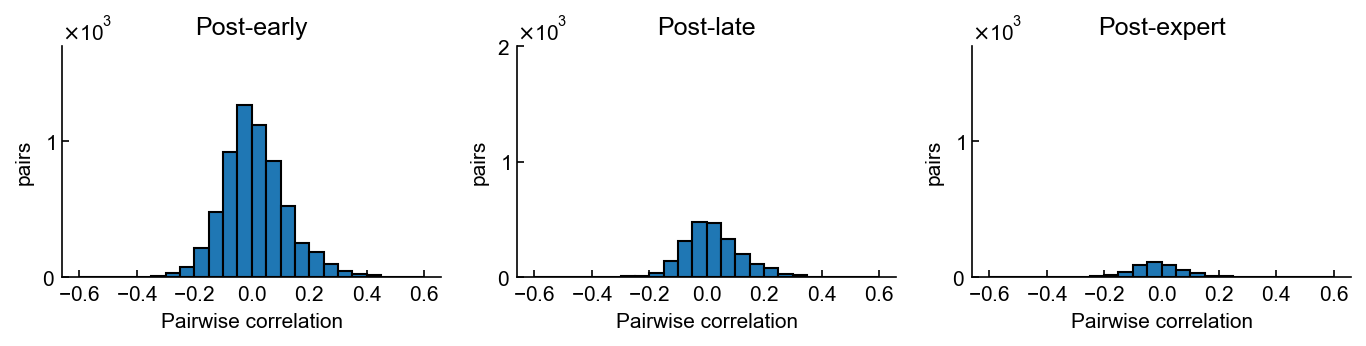

In [66]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
num_bins = 24

ax1.hist(postearly_corr,bins=num_bins, range=(-0.6,0.6),edgecolor='k')
ax1.set_xticks([-0.6, -0.4, -0.2,  0,  0.2,  0.4,  0.6])
ax1.set_yticks([0,1000,2000])
ax1.set_ylim([0,1700])
ax1.set_xlabel('Pairwise correlation')
ax1.set_ylabel('pairs')
ax1.set_title('Post-early')

ax2.hist(postlate_corr,bins=num_bins,range=(-0.6,0.6),edgecolor='k')
ax2.set_xticks([-0.6, -0.4, -0.2,  0,  0.2,  0.4,  0.6])
ax2.set_yticks([0,1000,2000])
ax2.set_ylim([0,2000])
ax2.set_xlabel('Pairwise correlation')
ax2.set_ylabel('pairs')
ax2.set_title('Post-late')

ax3.hist(postexpert_corr,bins=num_bins, range=(-0.6,0.6),edgecolor='k')
ax3.set_xticks([-0.6, -0.4, -0.2,  0,  0.2,  0.4,  0.6])
ax3.set_yticks([0,1000,2000])
ax3.set_ylim([0,1700])
ax3.set_xlabel('Pairwise correlation')
ax3.set_ylabel('pairs')
ax3.set_title('Post-expert')

## Probability Density Functions

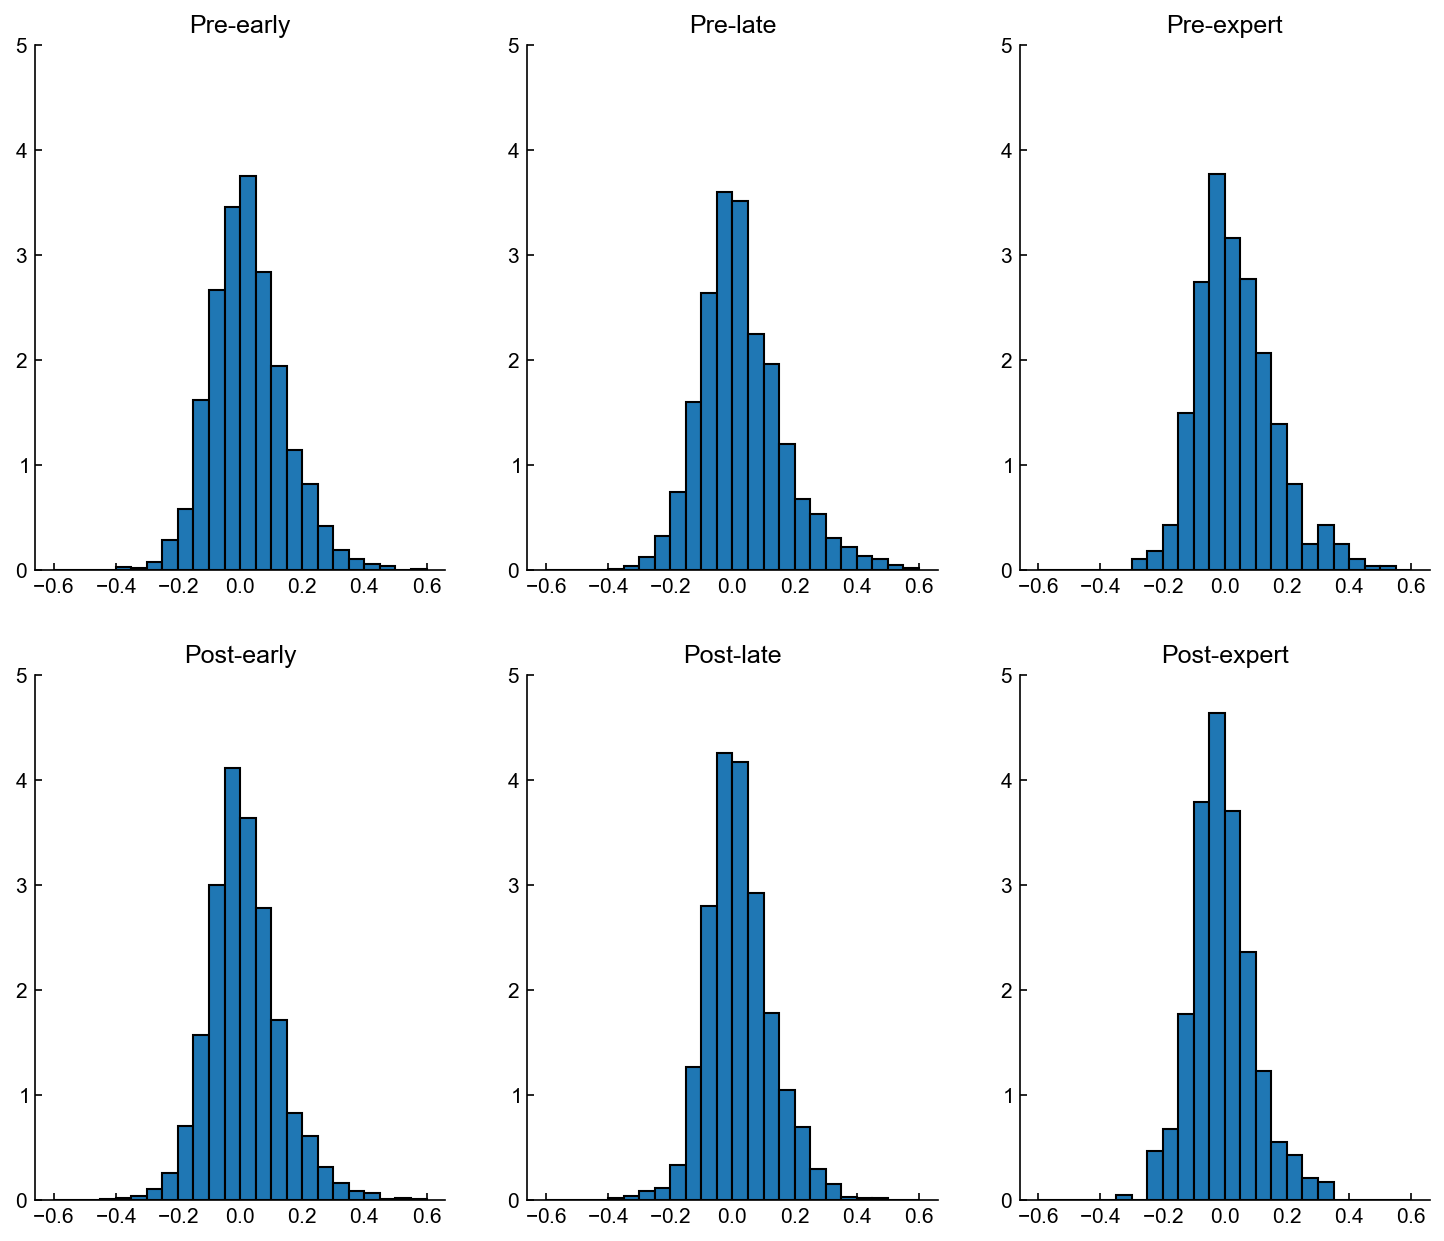

In [67]:
dataset = [preearly_corr, prelate_corr, preexpert_corr, postearly_corr, postlate_corr, postexpert_corr]
labels = ['Pre-early', 'Pre-late', 'Pre-expert', 'Post-early', 'Post-late', 'Post-expert']

fig = plt.figure(figsize=(12,10))

for i, data in enumerate(dataset, 1):
    plt.subplot(2,3,i)
    plt.hist(data, bins=24, density = True, range=(-0.6,0.6),edgecolor='k')
    plt.title(labels[i-1])
    plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
    plt.yticks([0, 1, 2, 3, 4, 5])
    
plt.show()

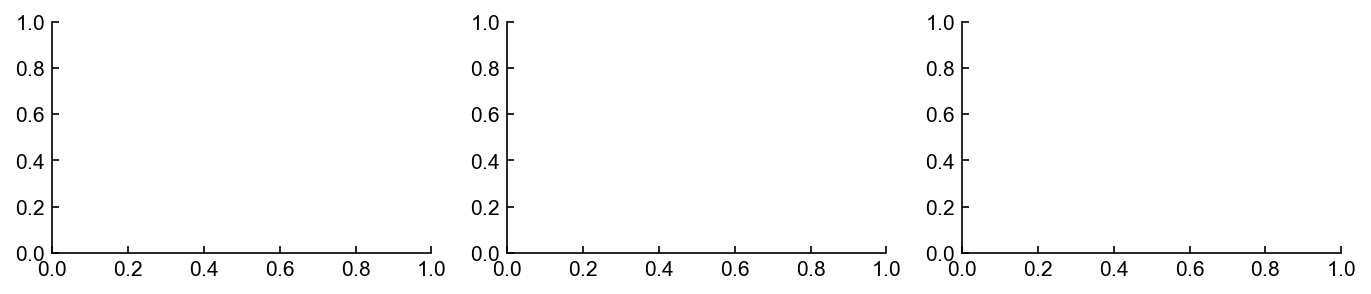

In [68]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax4 = plt.subplot(gs[0,0])
ax5 = plt.subplot(gs[0,1])
ax6= plt.subplot(gs[0,2])

## Normalize the histograms

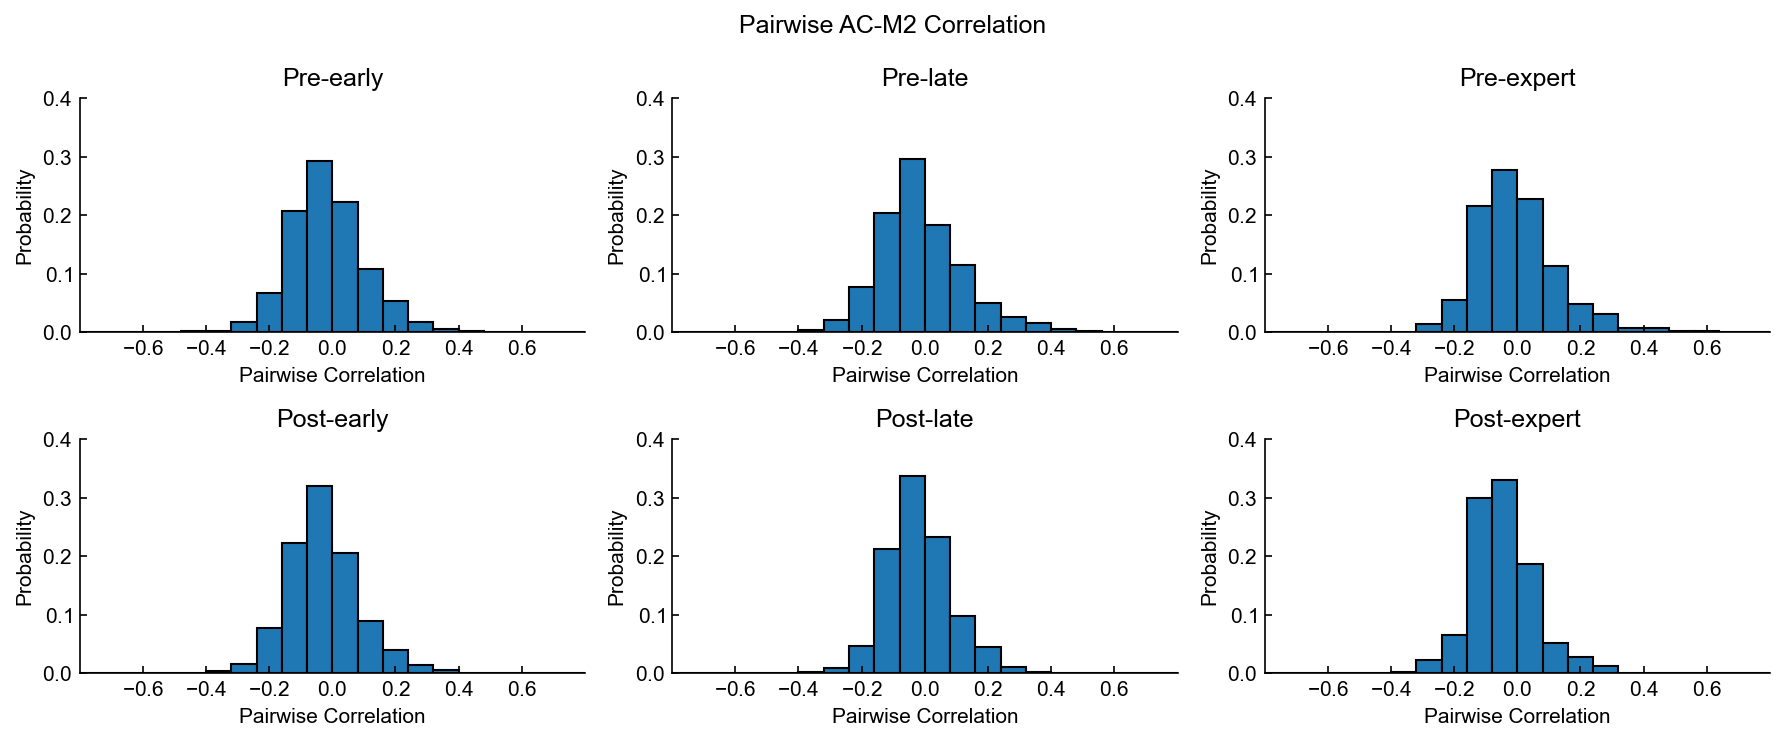

In [142]:
num_bins = 25

hist_preearly, bins_preearly, _ = ax1.hist(preearly_corr,bins=num_bins, range=(-1,1),edgecolor='k')
hist_prelate, bins_prelate, _ = ax2.hist(prelate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_preexpert, bins_preexpert, _ =  ax3.hist(preexpert_corr,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postearly, bins_postearly, _ = ax4.hist(postearly_corr,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postlate, bins_postlate, _ = ax5.hist(postlate_corr,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postexpert, bins_postexpert, _ = ax6.hist(postexpert_corr,bins=num_bins, range=(-1,1),edgecolor='k')


normalize_preearly = hist_preearly / sum(hist_preearly)
normalize_prelate = hist_prelate / sum(hist_prelate)
normalize_preexpert = hist_preexpert / sum(hist_preexpert)
normalize_postearly = hist_postearly / sum (hist_postearly)
normalize_postlate = hist_postlate / sum(hist_postlate)
normalize_postexpert = hist_postexpert / sum(hist_postexpert)

normalize = [normalize_preearly, normalize_prelate, normalize_preexpert, normalize_postearly, normalize_postlate, normalize_postexpert]
labels = ['Pre-early', 'Pre-late', 'Pre-expert', 'Post-early', 'Post-late', 'Post-expert']

fig = plt.figure(figsize=(12,5))

plt.subplot(2,3,1)
plt.bar(bins_preearly[:-1], normalize_preearly, width=np.diff(bins_preearly), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.title('Pre-early')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,2)
plt.bar(bins_prelate[:-1], normalize_prelate, width=np.diff(bins_prelate), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Pre-late')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,3)
plt.bar(bins_preexpert[:-1], normalize_preexpert, width=np.diff(bins_preexpert), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Pre-expert')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')


plt.subplot(2,3,4)
plt.bar(bins_postearly[:-1], normalize_postearly, width=np.diff(bins_postearly), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.title('Post-early')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,5)
plt.bar(bins_postlate[:-1], normalize_postlate, width=np.diff(bins_postlate), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Post-late')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,6)
plt.bar(bins_postexpert[:-1], normalize_postexpert, width=np.diff(bins_postexpert), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Post-expert')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')


plt.suptitle('Pairwise AC-M2 Correlation')
plt.tight_layout()
plt.show()

## Mean and Std of correlation 

In [106]:
preearly_corr = np.array(preearly_corr)
prelate_corr = np.array(prelate_corr)
preexpert_corr = np.array(preexpert_corr)
postearly_corr = np.array(postearly_corr)
postlate_corr = np.array(postlate_corr)
postexpert_corr = np.array(postexpert_corr)


pre_early_corr = preearly_corr[~np.isnan(preearly_corr)]
pre_late_corr = prelate_corr[~np.isnan(prelate_corr)]
pre_expert_corr = preexpert_corr[~np.isnan(preexpert_corr)]
post_early_corr = postearly_corr[~np.isnan(postearly_corr)]
post_late_corr = postlate_corr[~np.isnan(postlate_corr)]
post_expert_corr = postexpert_corr[~np.isnan(postexpert_corr)]

In [119]:
mean_preearly_corr = np.mean(pre_early_corr)
std_preearly_corr = np.std(pre_early_corr)

mean_prelate_corr = np.mean(pre_late_corr)
std_prelate_corr = np.std(pre_late_corr)

mean_preexpert_corr = np.mean(pre_expert_corr)
std_preexpert_corr = np.std(pre_expert_corr)

mean_postearly_corr = np.mean(post_early_corr)
std_postearly_corr = np.std(post_early_corr)

mean_postlate_corr = np.mean(post_late_corr)
std_postlate_corr = np.std(post_late_corr)

mean_postexpert_corr = np.mean(post_expert_corr)
std_postexpert_corr = np.std(post_expert_corr)

In [112]:
means = [mean_preearly_corr, mean_prelate_corr, mean_preexpert_corr, mean_postearly_corr, mean_postlate_corr, mean_postexpert_corr]
stds = [std_preearly_corr, std_prelate_corr, std_preexpert_corr, std_postearly_corr, std_postlate_corr, std_postexpert_corr]
print('mean = ', means)
print('std = ', stds)

mean =  [0.024787920503282577, 0.02909618548681339, 0.03581343363821128, 0.013218554011844798, 0.02219391257948441, -0.005914555025065704]
std =  [0.11794396741098087, 0.1337565715505791, 0.12764327326625582, 0.11665714750044057, 0.10378463006965558, 0.09941100339260568]


In [113]:
all_correlations = [preearly_corr, prelate_corr, preexpert_corr, postearly_corr, postlate_corr, postexpert_corr]

## Saving correlations as pcikle files

In [118]:
#Create pickle file
AC_M2_pairwise_corr_with_nan = SimpleNamespace(prereversal_early=preearly_corr,
                      prereversal_late=prelate_corr,
                      prereversal_expert=preexpert_corr,
                      postreversal_early=postearly_corr,
                      postreversal_late=postlate_corr,
                      postreversal_expert=postexpert_corr
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

## Plotting mean correlations

In [122]:
names = ['Pre_early', 'Pre_late', 'Pre_expert','Post-early','Post-late','Post-expert'] 

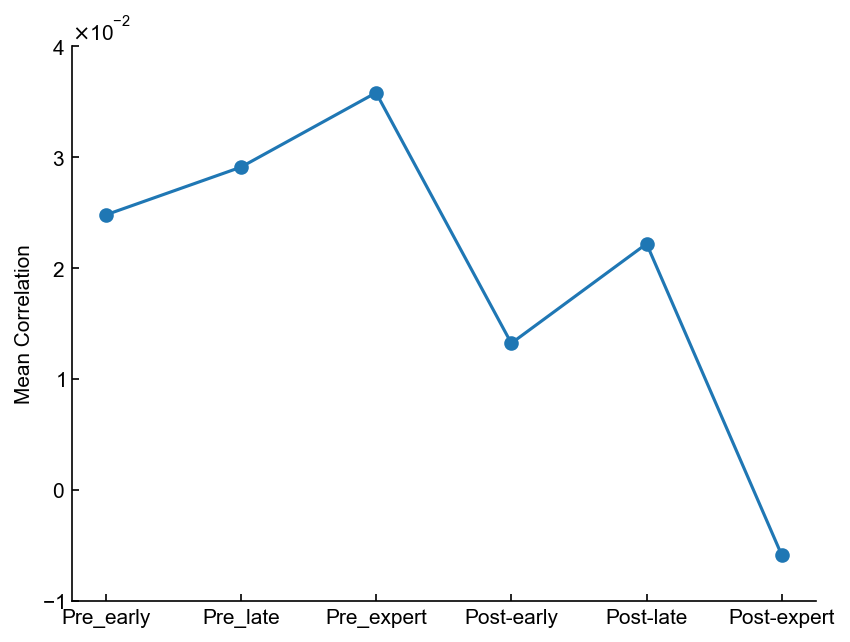

In [227]:
plt.plot(names, means, '-o')
plt.yticks([-0.01, 0, 0.01, 0.02, 0.03, 0.04])
plt.ylabel('Mean Correlation')
# plt.errorbar(names, means, yerr = stds)
plt.show()

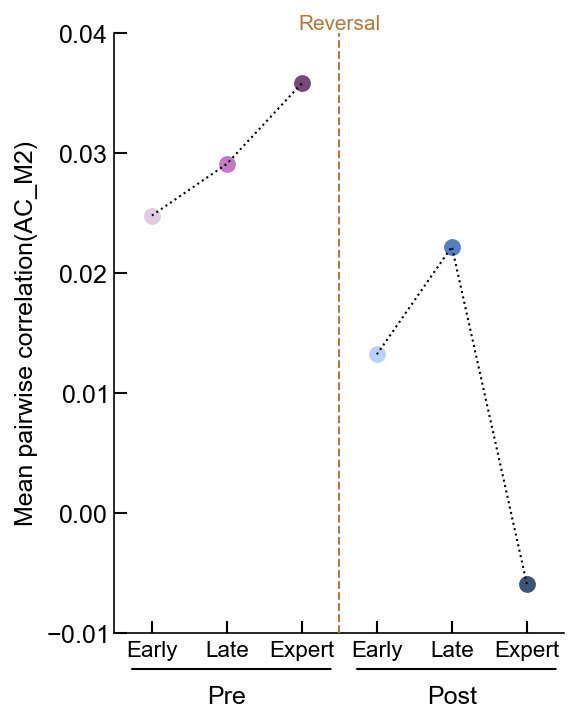

In [279]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr, mean_prelate_corr, mean_preexpert_corr, mean_postearly_corr, mean_postlate_corr, mean_postexpert_corr]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.01,0.04])
ylab = ax.set_ylabel('Mean pairwise correlation(AC_M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)
### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)
artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Figure2\\Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# TARGET TRIALS

In [151]:
def getTargetTrialstoUse(session_AC, session_M2, clustAC, clustM2):
    trials_AC = ilep.getAllConditions(session_AC,clustAC,trialsPerDayLoaded=None)['target']
    trials_M2 = ilep.getAllConditions(session_M2,clustM2,trialsPerDayLoaded=None)['target']
    trials_AC = trials_AC.trials
    trials_M2 = trials_M2.trials
    trials_to_use = np.intersect1d(trials_AC,trials_M2)
    return trials_to_use

In [152]:
def getACM2PearsonCorrelationTarget(AC_session):
    correlation = []
    p_value = []
    session_AC, session_M2, clust_AC, clust_M2, cluster_pairs = getPairsACM2_AndClustersPairs(AC_session)
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        trials_to_use = getTargetTrialstoUse(session_AC, session_M2, AC_clust, M2_clust)
        if len(trials_to_use) >= 100:
            resSpikeCountAC, resSpikeCountM2 = getResSpikeCounts(trials_to_use, session_AC, session_M2, AC_clust, M2_clust, 0.2)
            corr, p_val = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            p_value.append(p_val)

    return correlation, p_value

In [154]:
preearly_corr_target = []

for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelationTarget(session)
    preearly_corr_target.extend(correlation)

In [175]:
prelate_corr_target = []
for session in AC_prelate:
    correlation_tar_pl, pval_tar_pl = getACM2PearsonCorrelationTarget(session)
    prelate_corr_target.extend(correlation_tar_pl)

In [176]:
preexpert_corr_target = []
for session in AC_preexpert:
    correlation_tar_pe, pval_tar_pe = getACM2PearsonCorrelationTarget(session)
    preexpert_corr_target.extend(correlation_tar_pe)

In [177]:
postearly_corr_target = []
for session in AC_postearly:
    correlation_tar_poe, pval_tar_poe = getACM2PearsonCorrelationTarget(session)
    postearly_corr_target.extend(correlation_tar_poe)

In [178]:
postlate_corr_target = []
for session in AC_postlate:
    correlation_tar_pol, pval_tar_pol = getACM2PearsonCorrelationTarget(session)
    postlate_corr_target.extend(correlation_tar_pol)

In [179]:
postexpert_corr_target = []
for session in AC_postexpert:
    correlation_tar_poex, pval_tar_poex = getACM2PearsonCorrelationTarget(session)
    postexpert_corr_target.extend(correlation_tar_poex)

## Normalized Histograms for target trials only

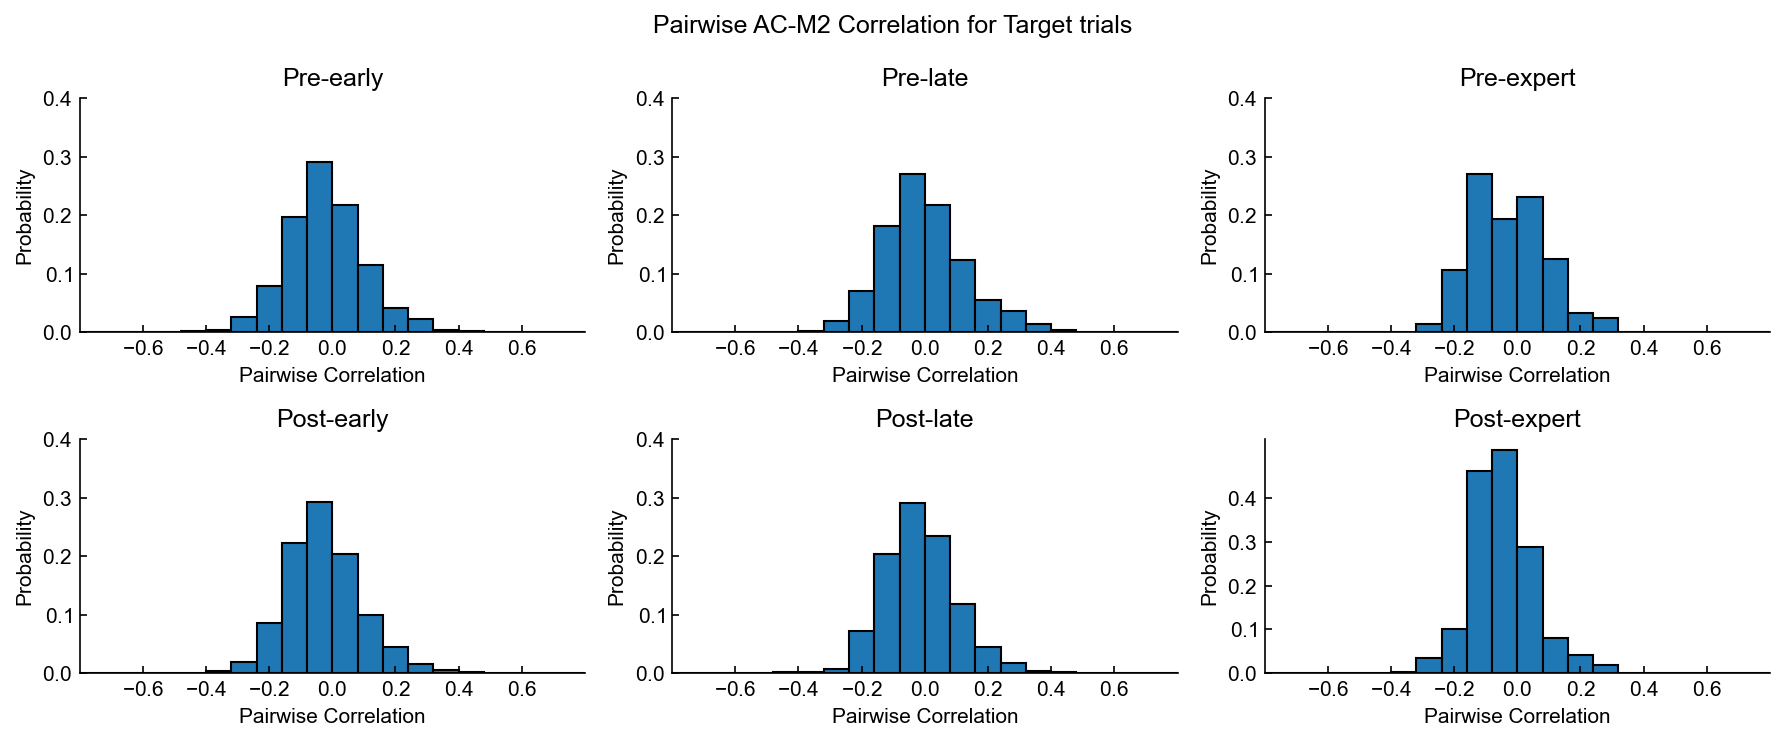

In [188]:
num_bins = 25

hist_preearly_tar, bins_preearly_tar, _ = ax1.hist(preearly_corr_target,bins=num_bins, range=(-1,1),edgecolor='k')
hist_prelate_tar, bins_prelate_tar, _ = ax2.hist(prelate_corr_target,bins=num_bins,range=(-1,1),edgecolor='k')
hist_preexpert_tar, bins_preexpert_tar, _ =  ax3.hist(preexpert_corr_target,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postearly_tar, bins_postearly_tar, _ = ax4.hist(postearly_corr_target,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postlate_tar, bins_postlate_tar, _ = ax5.hist(postlate_corr_target,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postexpert_tar, bins_postexpert_tar, _ = ax6.hist(postexpert_corr_target,bins=num_bins, range=(-1,1),edgecolor='k')


normalize_preearly_tar = hist_preearly_tar / sum(hist_preearly_tar)
normalize_prelate_tar = hist_prelate_tar / sum(hist_prelate_tar)
normalize_preexpert_tar = hist_preexpert_tar / sum(hist_preexpert_tar)
normalize_postearly_tar = hist_postearly_tar / sum (hist_postearly_tar)
normalize_postlate_tar = hist_postlate_tar / sum(hist_postlate_tar)
normalize_postexpert_tar = hist_postexpert / sum(hist_postexpert_tar)

normalize = [normalize_preearly_tar, normalize_prelate_tar, normalize_preexpert_tar, normalize_postearly_tar, normalize_postlate_tar, normalize_postexpert_tar]
labels = ['Pre-early', 'Pre-late', 'Pre-expert', 'Post-early', 'Post-late', 'Post-expert']

fig = plt.figure(figsize=(12,5))

plt.subplot(2,3,1)
plt.bar(bins_preearly[:-1], normalize_preearly_tar, width=np.diff(bins_preearly_tar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.title('Pre-early')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,2)
plt.bar(bins_prelate[:-1], normalize_prelate_tar, width=np.diff(bins_prelate_tar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Pre-late')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,3)
plt.bar(bins_preexpert[:-1], normalize_preexpert_tar, width=np.diff(bins_preexpert_tar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Pre-expert')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')


plt.subplot(2,3,4)
plt.bar(bins_postearly[:-1], normalize_postearly_tar, width=np.diff(bins_postearly_tar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.title('Post-early')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,5)
plt.bar(bins_postlate[:-1], normalize_postlate_tar, width=np.diff(bins_postlate_tar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Post-late')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,6)
plt.bar(bins_postexpert[:-1], normalize_postexpert_tar, width=np.diff(bins_postexpert_tar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Post-expert')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')


plt.suptitle('Pairwise AC-M2 Correlation for Target trials')
plt.tight_layout()
plt.show()

## Mean and STD

In [189]:
preearly_corr_target = np.array(preearly_corr_target)
prelate_corr_target = np.array(prelate_corr_target)
preexpert_corr_target = np.array(preexpert_corr_target)
postearly_corr_target = np.array(postearly_corr_target)
postlate_corr_target = np.array(postlate_corr_target)
postexpert_corr_target = np.array(postexpert_corr_target)


pre_early_corr_target = preearly_corr_target[~np.isnan(preearly_corr_target)]
pre_late_corr_target = prelate_corr_target[~np.isnan(prelate_corr_target)]
pre_expert_corr_target = preexpert_corr_target[~np.isnan(preexpert_corr_target)]
post_early_corr_target = postearly_corr_target[~np.isnan(postearly_corr_target)]
post_late_corr_target = postlate_corr_target[~np.isnan(postlate_corr_target)]
post_expert_corr_target = postexpert_corr_target[~np.isnan(postexpert_corr_target)]

In [190]:
mean_preearly_corr_target = np.mean(pre_early_corr_target)
std_preearly_corr_target = np.std(pre_early_corr_target)

mean_prelate_corr_target = np.mean(pre_late_corr_target)
std_prelate_corr_target = np.std(pre_late_corr_target)

mean_preexpert_corr_target = np.mean(pre_expert_corr_target)
std_preexpert_corr_target = np.std(pre_expert_corr_target)

mean_postearly_corr_target = np.mean(post_early_corr_target)
std_postearly_corr_target = np.std(post_early_corr_target)

mean_postlate_corr_target = np.mean(post_late_corr_target)
std_postlate_corr_target = np.std(post_late_corr_target)

mean_postexpert_corr_target = np.mean(post_expert_corr_target)
std_postexpert_corr_target = np.std(post_expert_corr_target)

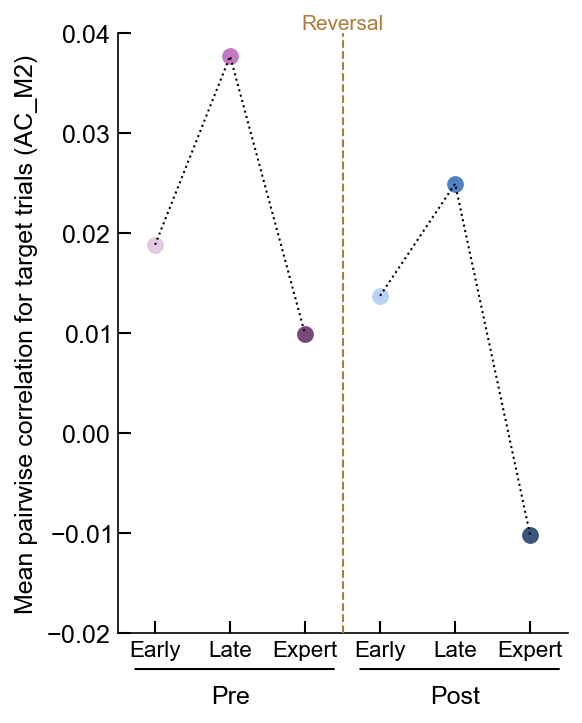

In [278]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr_target, mean_prelate_corr_target, mean_preexpert_corr_target, mean_postearly_corr_target, mean_postlate_corr_target, mean_postexpert_corr_target]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.02,0.04])
ylab = ax.set_ylabel('Mean pairwise correlation for target trials (AC_M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)
### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)
artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

## Saving target correlation as pickle files

In [192]:
#Create pickle file
AC_M2_pairwise_corr_target_with_nan = SimpleNamespace(prereversal_early=preearly_corr_target,
                      prereversal_late=prelate_corr_target,
                      prereversal_expert=preexpert_corr_target,
                      postreversal_early=postearly_corr_target,
                      postreversal_late=postlate_corr_target,
                      postreversal_expert=postexpert_corr_target
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_target_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_target_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

# NON TARGET TRIALS

In [180]:
def getNonTargetTrialstoUse(session_AC, session_M2, clustAC, clustM2):
    trials_AC = ilep.getAllConditions(session_AC,clustAC,trialsPerDayLoaded=None)['nontarget']
    trials_M2 = ilep.getAllConditions(session_M2,clustM2,trialsPerDayLoaded=None)['nontarget']
    trials_AC = trials_AC.trials
    trials_M2 = trials_M2.trials
    trials_to_use = np.intersect1d(trials_AC,trials_M2)
    return trials_to_use

In [181]:
def getACM2PearsonCorrelationNonTarget(AC_session):
    correlation = []
    p_value = []
    session_AC, session_M2, clust_AC, clust_M2, cluster_pairs = getPairsACM2_AndClustersPairs(AC_session)
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        trials_to_use = getNonTargetTrialstoUse(session_AC, session_M2, AC_clust, M2_clust)
        if len(trials_to_use) >= 100:
            resSpikeCountAC, resSpikeCountM2 = getResSpikeCounts(trials_to_use, session_AC, session_M2, AC_clust, M2_clust, 0.2)
            corr, p_val = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            p_value.append(p_val)

    return correlation, p_value

In [182]:
preearly_corr_nontarget = []

for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelationNonTarget(session)
    preearly_corr_nontarget.extend(correlation)

In [183]:
prelate_corr_nontarget = []
for session in AC_prelate:
    correlation_nontar_pl, pval_nontar_pl = getACM2PearsonCorrelationNonTarget(session)
    prelate_corr_nontarget.extend(correlation_nontar_pl)

In [184]:
preexpert_corr_nontarget = []
for session in AC_preexpert:
    correlation_nontar_pe, pval_nontar_pe = getACM2PearsonCorrelationNonTarget(session)
    preexpert_corr_nontarget.extend(correlation_nontar_pe)

In [185]:
postearly_corr_nontarget = []
for session in AC_postearly:
    correlation_nontar_poe, pval_nontar_poe = getACM2PearsonCorrelationNonTarget(session)
    postearly_corr_nontarget.extend(correlation_nontar_poe)

In [186]:
postlate_corr_nontarget = []
for session in AC_postlate:
    correlation_nontar_pol, pval_nontar_pol = getACM2PearsonCorrelationNonTarget(session)
    postlate_corr_nontarget.extend(correlation_nontar_pol)

In [187]:
postexpert_corr_nontarget = []
for session in AC_postexpert:
    correlation_nontar_poex, pval_nontar_poex = getACM2PearsonCorrelationNonTarget(session)
    postexpert_corr_nontarget.extend(correlation_nontar_poex)

## Normalized Histograms for non target trials

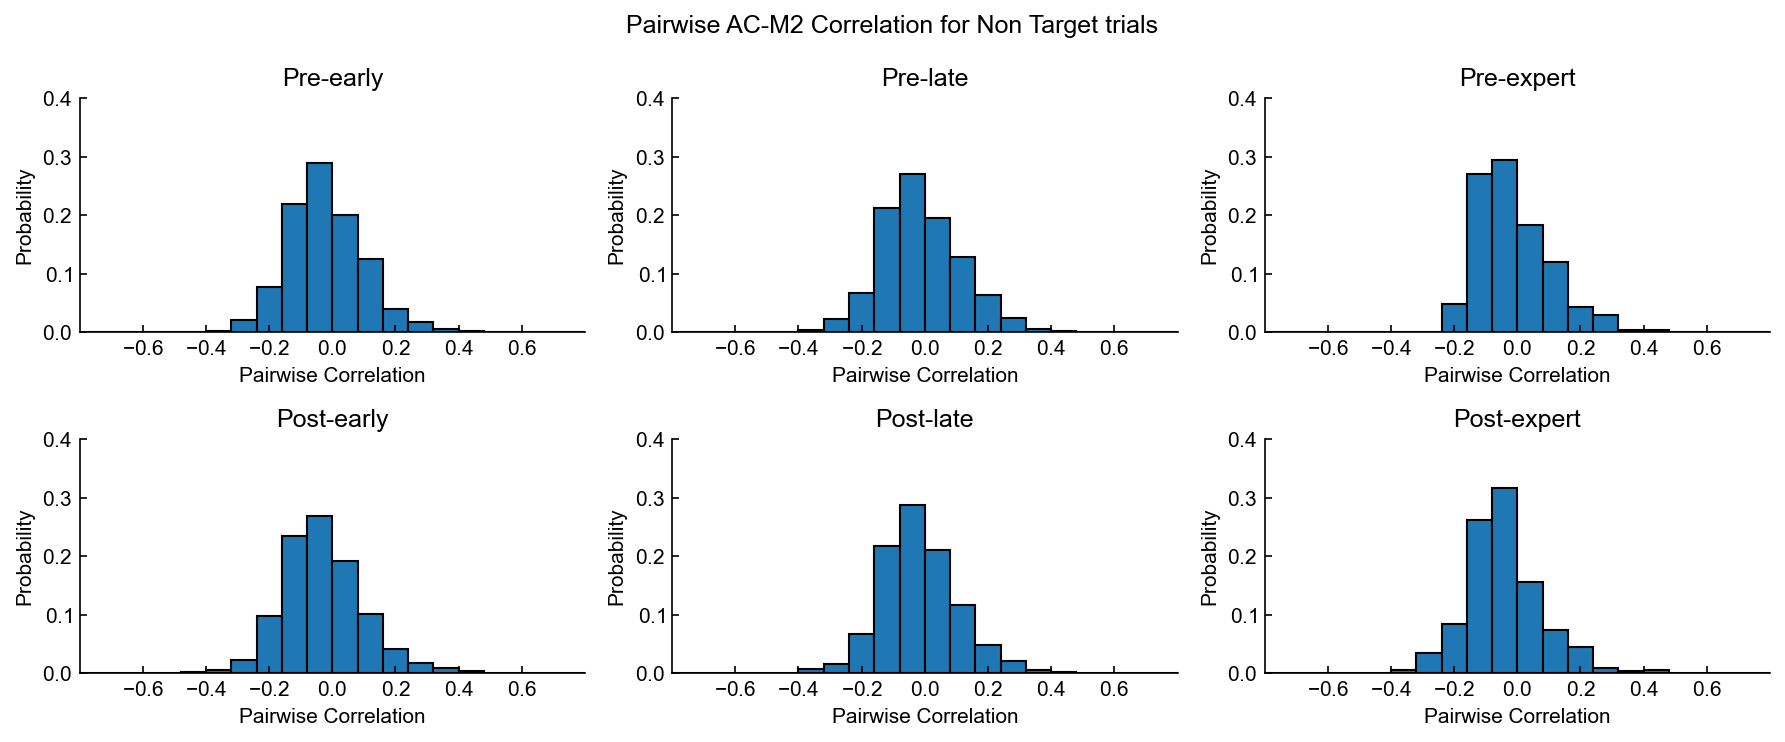

In [193]:
num_bins = 25

hist_preearly_nontar, bins_preearly_nontar, _ = ax1.hist(preearly_corr_nontarget,bins=num_bins, range=(-1,1),edgecolor='k')
hist_prelate_nontar, bins_prelate_nontar, _ = ax2.hist(prelate_corr_nontarget,bins=num_bins,range=(-1,1),edgecolor='k')
hist_preexpert_nontar, bins_preexpert_nontar, _ =  ax3.hist(preexpert_corr_nontarget,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postearly_nontar, bins_postearly_nontar, _ = ax4.hist(postearly_corr_nontarget,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postlate_nontar, bins_postlate_nontar, _ = ax5.hist(postlate_corr_nontarget,bins=num_bins, range=(-1,1),edgecolor='k')
hist_postexpert_nontar, bins_postexpert_nontar, _ = ax6.hist(postexpert_corr_nontarget,bins=num_bins, range=(-1,1),edgecolor='k')


normalize_preearly_nontar = hist_preearly_nontar / sum(hist_preearly_nontar)
normalize_prelate_nontar = hist_prelate_nontar / sum(hist_prelate_nontar)
normalize_preexpert_nontar = hist_preexpert_nontar / sum(hist_preexpert_nontar)
normalize_postearly_nontar = hist_postearly_nontar / sum (hist_postearly_nontar)
normalize_postlate_nontar = hist_postlate_nontar / sum(hist_postlate_nontar)
normalize_postexpert_nontar = hist_postexpert_nontar / sum(hist_postexpert_nontar)

normalize = [normalize_preearly_nontar, normalize_prelate_nontar, normalize_preexpert_nontar, normalize_postearly_nontar, normalize_postlate_nontar, normalize_postexpert_nontar]
labels = ['Pre-early', 'Pre-late', 'Pre-expert', 'Post-early', 'Post-late', 'Post-expert']

fig = plt.figure(figsize=(12,5))

plt.subplot(2,3,1)
plt.bar(bins_preearly[:-1], normalize_preearly_nontar, width=np.diff(bins_preearly_nontar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.title('Pre-early')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,2)
plt.bar(bins_prelate[:-1], normalize_prelate_nontar, width=np.diff(bins_prelate_nontar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Pre-late')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,3)
plt.bar(bins_preexpert[:-1], normalize_preexpert_nontar, width=np.diff(bins_preexpert_nontar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Pre-expert')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')


plt.subplot(2,3,4)
plt.bar(bins_postearly[:-1], normalize_postearly_nontar, width=np.diff(bins_postearly_nontar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.title('Post-early')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,5)
plt.bar(bins_postlate[:-1], normalize_postlate_nontar, width=np.diff(bins_postlate_nontar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Post-late')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')

plt.subplot(2,3,6)
plt.bar(bins_postexpert[:-1], normalize_postexpert_nontar, width=np.diff(bins_postexpert_nontar), edgecolor='k')
plt.xlim([-0.8, 0.8])
plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.title('Post-expert')
plt.ylabel('Probability')
plt.xlabel('Pairwise Correlation')


plt.suptitle('Pairwise AC-M2 Correlation for Non Target trials')
plt.tight_layout()
plt.show()

## Mean and STD

In [194]:
preearly_corr_nontarget = np.array(preearly_corr_nontarget)
prelate_corr_nontarget = np.array(prelate_corr_nontarget)
preexpert_corr_nontarget = np.array(preexpert_corr_nontarget)
postearly_corr_nontarget = np.array(postearly_corr_nontarget)
postlate_corr_nontarget = np.array(postlate_corr_nontarget)
postexpert_corr_nontarget = np.array(postexpert_corr_nontarget)


pre_early_corr_nontarget = preearly_corr_nontarget[~np.isnan(preearly_corr_nontarget)]
pre_late_corr_nontarget = prelate_corr_nontarget[~np.isnan(prelate_corr_nontarget)]
pre_expert_corr_nontarget = preexpert_corr_nontarget[~np.isnan(preexpert_corr_nontarget)]
post_early_corr_nontarget = postearly_corr_nontarget[~np.isnan(postearly_corr_nontarget)]
post_late_corr_nontarget = postlate_corr_nontarget[~np.isnan(postlate_corr_nontarget)]
post_expert_corr_nontarget = postexpert_corr_nontarget[~np.isnan(postexpert_corr_nontarget)]

In [195]:
mean_preearly_corr_nontarget = np.mean(pre_early_corr_nontarget)
std_preearly_corr_nontarget = np.std(pre_early_corr_nontarget)

mean_prelate_corr_nontarget = np.mean(pre_late_corr_nontarget)
std_prelate_corr_nontarget = np.std(pre_late_corr_nontarget)

mean_preexpert_corr_nontarget = np.mean(pre_expert_corr_nontarget)
std_preexpert_corr_nontarget = np.std(pre_expert_corr_nontarget)

mean_postearly_corr_nontarget = np.mean(post_early_corr_nontarget)
std_postearly_corr_nontarget = np.std(post_early_corr_nontarget)

mean_postlate_corr_nontarget = np.mean(post_late_corr_nontarget)
std_postlate_corr_nontarget = np.std(post_late_corr_nontarget)

mean_postexpert_corr_nontarget = np.mean(post_expert_corr_nontarget)
std_postexpert_corr_nontarget = np.std(post_expert_corr_nontarget)

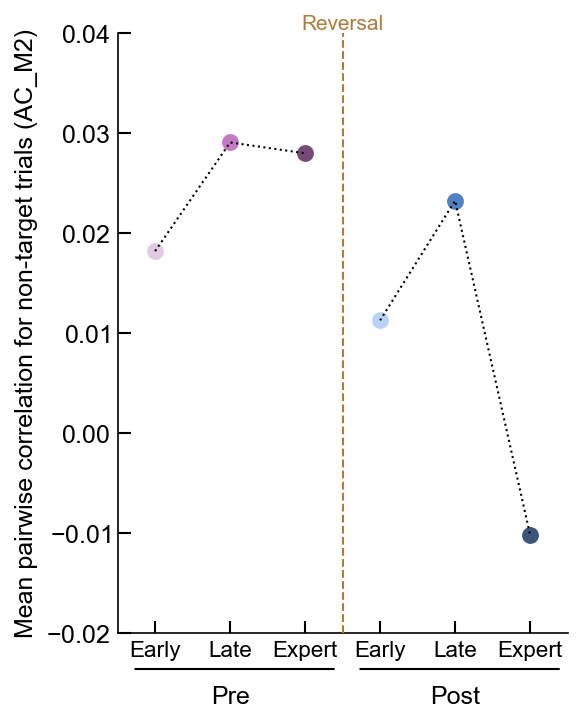

In [277]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr_nontarget, mean_prelate_corr_nontarget, mean_preexpert_corr_nontarget, mean_postearly_corr_nontarget, mean_postlate_corr_nontarget, mean_postexpert_corr_target]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.02,0.04])
ylab = ax.set_ylabel('Mean pairwise correlation for non-target trials (AC_M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

In [262]:
# ax.errorbar(x, data, std_nontarget,  fmt='none')

## Saving non target correlations as pickle file

In [221]:
#Create pickle file
AC_M2_pairwise_corr_nontarget_with_nan = SimpleNamespace(prereversal_early=preearly_corr_nontarget,
                      prereversal_late=prelate_corr_nontarget,
                      prereversal_expert=preexpert_corr_nontarget,
                      postreversal_early=postearly_corr_nontarget,
                      postreversal_late=postlate_corr_nontarget,
                      postreversal_expert=postexpert_corr_nontarget
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_nontarget_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_nontarget_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

# Significance Test (Statistics.py)

## Non target

In [223]:
AC_M2_pairwise_nontarget = SimpleNamespace(preearly = preearly_corr_nontarget,
                                           prelate = prelate_corr_nontarget,
                                           preexpert = preexpert_corr_nontarget,
                                           postearly = postearly_corr_nontarget,
                                           postlate = postlate_corr_nontarget,
                                           postexpert = postexpert_corr_nontarget
                                          )

In [251]:
pairwise_nontarget = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise_nontarget)

            Source          SS       DF        MS          F     p-unc  \
0            phase    0.220149      3.0  0.073383   4.561688  0.003374   
1          context    0.209545      1.0  0.209545  13.025901  0.000308   
2  phase * context    0.156866      3.0  0.052289   3.250406  0.020826   
3         Residual  286.200590  17791.0  0.016087        NaN       NaN   

        np2  
0  0.000769  
1  0.000732  
2  0.000548  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.074778  0.099704  0.100711
8     post-late  baseline  experimental  0.000019  0.000077 -0.093518
9    pre-expert  baseline  experimental  0.590476  0.590476 -0.083617
10     pre-late  baseline  experimental  0.020838  0.041675 -0.087272


In [252]:
pairwise_nontarget

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,17722969.5,two-sided,4.014694e-02,5.868613e-02,fdr_bh,-0.030876
1,phase,-,post-expert,pre-expert,False,False,3905718.0,two-sided,1.147764e-03,2.295529e-03,fdr_bh,-0.070719
2,phase,-,post-expert,pre-late,False,False,10042608.0,two-sided,8.226456e-11,4.935873e-10,fdr_bh,-0.117401
3,phase,-,post-late,pre-expert,False,False,5148113.0,two-sided,4.890510e-02,5.868613e-02,fdr_bh,-0.039706
4,phase,-,post-late,pre-late,False,False,13234392.0,two-sided,7.080476e-07,2.124143e-06,fdr_bh,-0.086767
5,phase,-,pre-expert,pre-late,False,False,3112132.0,two-sided,1.211212e-01,1.211212e-01,fdr_bh,-0.048911
6,context,-,baseline,experimental,False,False,30433398.0,two-sided,1.604043e-10,NaN,NaN,-0.097052
7,phase * context,post-expert,baseline,experimental,False,False,818272.0,two-sided,7.477804e-02,9.970406e-02,fdr_bh,0.100711
8,phase * context,post-late,baseline,experimental,False,False,4276634.0,two-sided,1.926686e-05,7.706743e-05,fdr_bh,-0.093518
9,phase * context,pre-expert,baseline,experimental,False,False,136483.0,two-sided,5.904756e-01,5.904756e-01,fdr_bh,-0.083617


In [273]:
#post-late **** 
#pre-late *

## Target

In [230]:
AC_M2_pairwise_target = SimpleNamespace(preearly = preearly_corr_target,
                                           prelate = prelate_corr_target,
                                           preexpert = preexpert_corr_target,
                                           postearly = postearly_corr_target,
                                           postlate = postlate_corr_target,
                                           postexpert = postexpert_corr_target
                                          )

In [249]:
pairwise_target = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise_target)

            Source          SS       DF        MS          F         p-unc  \
0            phase    0.390655      3.0  0.130218   8.785141  8.105358e-06   
1          context    0.225553      1.0  0.225553  15.216872  9.618180e-05   
2  phase * context    0.474538      3.0  0.158179  10.671518  5.264599e-07   
3         Residual  274.513853  18520.0  0.014823        NaN           NaN   

        np2  
0  0.001421  
1  0.000821  
2  0.001726  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000929  0.001238  0.201025
8     post-late  baseline  experimental  0.000033  0.000130 -0.094845
9    pre-expert  baseline  experimental  0.225061  0.225061  0.073389
10     pre-late  baseline  experimental  0.000169  0.000338 -0.144532


In [250]:
pairwise_target

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,18661053.0,two-sided,2.168738e-02,3.253107e-02,fdr_bh,-0.037167
1,phase,-,post-expert,pre-expert,False,False,4296927.0,two-sided,4.568898e-02,5.482677e-02,fdr_bh,-0.044546
2,phase,-,post-expert,pre-late,False,False,10977624.0,two-sided,1.756015e-13,1.053609e-12,fdr_bh,-0.154604
3,phase,-,post-late,pre-expert,False,False,5701892.0,two-sided,5.710034e-01,5.710034e-01,fdr_bh,-0.007764
4,phase,-,post-late,pre-late,False,False,14575565.0,two-sided,1.091550e-08,3.274649e-08,fdr_bh,-0.120322
5,phase,-,pre-expert,pre-late,False,False,3419748.0,two-sided,1.230955e-03,2.461910e-03,fdr_bh,-0.108251
6,context,-,baseline,experimental,False,False,33247042.0,two-sided,4.659335e-12,NaN,NaN,-0.119465
7,phase * context,post-expert,baseline,experimental,False,False,880323.0,two-sided,9.286803e-04,1.238240e-03,fdr_bh,0.201025
8,phase * context,post-late,baseline,experimental,False,False,4588525.0,two-sided,3.253480e-05,1.301392e-04,fdr_bh,-0.094845
9,phase * context,pre-expert,baseline,experimental,False,False,155500.0,two-sided,2.250612e-01,2.250612e-01,fdr_bh,0.073389


In [274]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

#post-expert **
#post-late ***
#pre-late ***

## All trials

In [238]:
AC_M2_pairwise = SimpleNamespace(preearly = pre_early_corr,
                                           prelate = pre_late_corr,
                                           preexpert = pre_expert_corr,
                                           postearly = post_early_corr,
                                           postlate = post_late_corr,
                                           postexpert = post_expert_corr
                                          )

In [247]:
pairwise_all = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise)

            Source          SS       DF        MS          F         p-unc  \
0            phase    0.879897      3.0  0.293299  20.890277  1.638045e-13   
1          context    0.085421      1.0  0.085421   6.084127  1.364658e-02   
2  phase * context    0.299938      3.0  0.099979   7.121034  8.884549e-05   
3         Residual  364.674408  25974.0  0.014040        NaN           NaN   

        np2  
0  0.002407  
1  0.000234  
2  0.000822  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000329  0.000657  0.165598
8     post-late  baseline  experimental  0.000021  0.000085 -0.079159
9    pre-expert  baseline  experimental  0.228605  0.304807 -0.092306
10     pre-late  baseline  experimental  0.915302  0.915302 -0.034060


In [248]:
pairwise_all

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,27297007.5,two-sided,1.375077e-02,1.650092e-02,fdr_bh,-0.032923
1,phase,-,post-expert,pre-expert,False,False,12042177.0,two-sided,4.391469e-10,1.317441e-09,fdr_bh,-0.124095
2,phase,-,post-expert,pre-late,False,False,21763116.0,two-sided,3.005748e-11,1.803449e-10,fdr_bh,-0.125200
3,phase,-,post-late,pre-expert,False,False,15618904.0,two-sided,5.674039e-06,8.511058e-06,fdr_bh,-0.093259
4,phase,-,post-late,pre-late,False,False,28215452.0,two-sided,2.399267e-06,4.798535e-06,fdr_bh,-0.095556
5,phase,-,pre-expert,pre-late,False,False,13784035.0,two-sided,6.501621e-01,6.501621e-01,fdr_bh,-0.005343
6,context,-,baseline,experimental,False,False,64273350.0,two-sided,3.887523e-04,NaN,NaN,-0.065143
7,phase * context,post-expert,baseline,experimental,False,False,1609299.0,two-sided,3.285168e-04,6.570336e-04,fdr_bh,0.165598
8,phase * context,post-late,baseline,experimental,False,False,6515567.0,two-sided,2.134209e-05,8.536835e-05,fdr_bh,-0.079159
9,phase * context,pre-expert,baseline,experimental,False,False,913713.0,two-sided,2.286049e-01,3.048065e-01,fdr_bh,-0.092306


In [275]:
#post-expert ***
#post-late ****

In [272]:
## For sampling?
# Do we sample the cells or just randomly sample the correlation values?
# What is the norm? How do you think people in these other literatures have done it?

In [271]:
# CR/NCR
# Is it not better to do sampling before we do CR/NCR since we have decided to do sampling anyway?

# ACC- CR/NCR Analysis

## Obtaining CR and NCR cells 

### CR

In [126]:
FRmod_baseline = 3.5533237685317998
NCR_AC_preearly = []
CR_AC_preearly = []

session = ilep.loadSessionCached(act_directory,AC_sessions[41])
for clust in session.clusters.good:
    if session.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
        NCR_AC_preearly.append(clust)
    else:
        CR_AC_preearly.append(clust)

In [326]:
AC_sessions_M2intersect = list(AC_sessions)
M2_sessions_ACintersect = list(M2_sessions)

In [328]:
type(AC_sessions_M2intersect)

list

In [336]:
for recording in AC_sessions_M2intersect:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_sessions_ACintersect:
        AC_sessions_M2intersect.remove(recording)

In [157]:
def getPairsACM2_And_CRClustersPairs(AC_session):
    session_AC = ilep.loadSessionCached(act_directory,AC_session)
    m2_name = AC_session.replace('AC','M2')
    index_M2 = M2_sessions_ACintersect.index(m2_name)
    session_M2 = ilep.loadSessionCached(act_directory,M2_sessions_ACintersect[index_M2])
    clust_AC = []
    for clust in session_AC.clusters.good:
        if session_AC.responsiveness[clust]['all_trials'].FRmodulation >= FRmod_baseline:
            clust_AC.append(clust)
    clust_M2 = session_M2.clusters.good
    cluster_pairs = list(product(clust_AC, clust_M2))
    return session_AC,session_M2, clust_AC, clust_M2, cluster_pairs

In [158]:
def getTrialstoUse(session_AC, session_M2, clustAC, clustM2):
    trials_AC = ilep.getAllConditions(session_AC,clustAC,trialsPerDayLoaded=None)['all_trials']
    trials_M2 = ilep.getAllConditions(session_M2,clustM2,trialsPerDayLoaded=None)['all_trials']
    trials_AC = trials_AC.trials
    trials_M2 = trials_M2.trials
    trials_to_use = np.intersect1d(trials_AC,trials_M2)
    return trials_to_use

In [159]:
def getResSpikeCounts(trials_to_use, session_AC,session_M2, clust_AC, clust_M2, window):
    start_trials = session_AC.trials.starts
    start_trials = [start_trials[trial_id] for trial_id in trials_to_use]
    spikeTimes_AC = [[]]
    spikeTimes_M2 = [[]]
    for trials in start_trials:
        end_time = trials + window*30000
        spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=clust_AC,starttime=trials,endtime=end_time,cachedtimes=None)
        spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=clust_M2,starttime=trials,endtime=end_time,cachedtimes=None)
        spikeTimes_AC.append(spikeTimes_1_AC)
        spikeTimes_M2.append(spikeTimes_1_M2)

    spikeCountsAC = []
    spikeCountsM2 = []
    spikeCountsAC = [len(row) for row in spikeTimes_AC]
    spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
    spikeCountsAC = np.array(spikeCountsAC)
    spikeCountsM2 = np.array(spikeCountsM2)
    mean_AC = np.mean(spikeCountsAC)
    mean_M2 = np.mean(spikeCountsM2)
    resSpikeCountAC = spikeCountsAC - mean_AC
    resSpikeCountM2 = spikeCountsM2 - mean_M2
    
    return resSpikeCountAC, resSpikeCountM2

In [160]:
def getACM2PearsonCorrelationCR(AC_session):
    correlation = []
    p_value = []
    session_AC, session_M2, clust_AC, clust_M2, cluster_pairs = getPairsACM2_And_CRClustersPairs(AC_session)
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        trials_to_use = getTrialstoUse(session_AC, session_M2, AC_clust, M2_clust)
        if len(trials_to_use) >= 100:
            resSpikeCountAC, resSpikeCountM2 = getResSpikeCounts(trials_to_use, session_AC, session_M2, AC_clust, M2_clust, 0.2)
            corr, p_val = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            p_value.append(p_val)

    return correlation, p_value

In [161]:
preearly_corr_CR = []
for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelationCR(session)
    preearly_corr_CR.extend(correlation)

In [162]:
prelate_corr_CR = []
for session in AC_prelate:
    correlation_pl, p_val = getACM2PearsonCorrelationCR(session)
    prelate_corr_CR.extend(correlation_pl)

In [131]:
preexpert_corr_CR = []
for session in AC_preexpert:
    correlation_pe, p_val = getACM2PearsonCorrelationCR(session)
    preexpert_corr_CR.extend(correlation_pe)

In [163]:
postearly_corr_CR = []
for session in AC_postearly:
    correlation_poe, p_val = getACM2PearsonCorrelationCR(session)
    postearly_corr_CR.extend(correlation_poe)

In [164]:
postlate_corr_CR = []
for session in AC_postlate:
    correlation_pol, p_val = getACM2PearsonCorrelationCR(session)
    postlate_corr_CR.extend(correlation_pol)

In [165]:
postexpert_corr_CR = []
for session in AC_postexpert:
    correlation_poex, p_val = getACM2PearsonCorrelationCR(session)
    postexpert_corr_CR.extend(correlation_poex)

#### Mean and STD

In [166]:
preearly_corr_CR = np.array(preearly_corr_CR)
prelate_corr_CR = np.array(prelate_corr_CR)
preexpert_corr_CR = np.array(preexpert_corr_CR)
postearly_corr_CR = np.array(postearly_corr_CR)
postlate_corr_CR = np.array(postlate_corr_CR)
postexpert_corr_CR = np.array(postexpert_corr_CR)


preearly_corr_CR = preearly_corr_CR[~np.isnan(preearly_corr_CR)]
prelate_corr_CR = prelate_corr_CR[~np.isnan(prelate_corr_CR)]
preexpert_corr_CR = preexpert_corr_CR[~np.isnan(preexpert_corr_CR)]
postearly_corr_CR = postearly_corr_CR[~np.isnan(postearly_corr_CR)]
postlate_corr_CR = postlate_corr_CR[~np.isnan(postlate_corr_CR)]
postexpert_corr_CR = postexpert_corr_CR[~np.isnan(postexpert_corr_CR)]

In [167]:
mean_preearly_corr_CR = np.mean(preearly_corr_CR)
std_preearly_corr_CR = np.std(preearly_corr_CR)

mean_prelate_corr_CR = np.mean(prelate_corr_CR)
std_prelate_corr_CR = np.std(prelate_corr_CR)

mean_preexpert_corr_CR = np.mean(preexpert_corr_CR)
std_preexpert_corr_CR = np.std(preexpert_corr_CR)

mean_postearly_corr_CR = np.mean(postearly_corr_CR)
std_postearly_corr_CR = np.std(postearly_corr_CR)

mean_postlate_corr_CR = np.mean(postlate_corr_CR)
std_postlate_corr_CR = np.std(postlate_corr_CR)

mean_postexpert_corr_CR = np.mean(postexpert_corr_CR)
std_postexpert_corr_CR = np.std(postexpert_corr_CR)

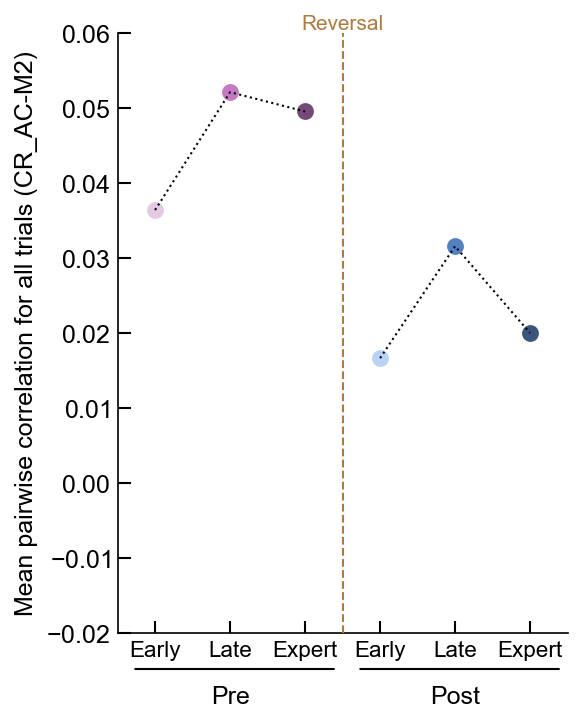

In [168]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr_CR, mean_prelate_corr_CR, mean_preexpert_corr_CR, mean_postearly_corr_CR, mean_postlate_corr_CR, mean_postexpert_corr_CR]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.02,0.06])
ylab = ax.set_ylabel('Mean pairwise correlation for all trials (CR_AC-M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

#### Saving pickle files

In [169]:
#Create pickle file
AC_M2_pairwise_corr_all_CR_AC_with_nan = SimpleNamespace(prereversal_early=preearly_corr_CR,
                      prereversal_late=prelate_corr_CR,
                      prereversal_expert=preexpert_corr_CR,
                      postreversal_early=postearly_corr_CR,
                      postreversal_late=postlate_corr_CR,
                      postreversal_expert=postexpert_corr_CR
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_all_CR_AC_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_all_CR_AC_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

#### Significance Test

In [170]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [171]:
AC_M2_pairwise_corr_all_CR_AC_with_nan = SimpleNamespace(preearly=preearly_corr_CR,
                      prelate=prelate_corr_CR,
                      preexpert=preexpert_corr_CR,
                      postearly=postearly_corr_CR,
                      postlate=postlate_corr_CR,
                      postexpert=postexpert_corr_CR
                     )

pairwise_AC_CR = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise_corr_all_CR_AC_with_nan)

            Source          SS       DF        MS          F         p-unc  \
0            phase    1.084145      3.0  0.361382  20.912292  1.651393e-13   
1          context    0.370381      1.0  0.370381  21.433060  3.701461e-06   
2  phase * context    0.015575      3.0  0.005192   0.300420  8.251230e-01   
3         Residual  212.692491  12308.0  0.017281        NaN           NaN   

        np2  
0  0.005071  
1  0.001738  
2  0.000073  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.825365  0.825365 -0.026302
8     post-late  baseline  experimental  0.000184  0.000735 -0.119338
9    pre-expert  baseline  experimental  0.232539  0.310052 -0.098069
10     pre-late  baseline  experimental  0.124268  0.248537 -0.109510


### NCR

In [172]:
def getPairsACM2_And_NCRClustersPairs(AC_session):
    session_AC = ilep.loadSessionCached(act_directory,AC_session)
    m2_name = AC_session.replace('AC','M2')
    index_M2 = M2_sessions_ACintersect.index(m2_name)
    session_M2 = ilep.loadSessionCached(act_directory,M2_sessions_ACintersect[index_M2])
    clust_AC = []
    for clust in session_AC.clusters.good:
        if session_AC.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
            clust_AC.append(clust)
    clust_M2 = session_M2.clusters.good
    cluster_pairs = list(product(clust_AC, clust_M2))
    return session_AC,session_M2, clust_AC, clust_M2, cluster_pairs

In [173]:
def getACM2PearsonCorrelationNCR(AC_session):
    correlation = []
    p_value = []
    session_AC, session_M2, clust_AC, clust_M2, cluster_pairs = getPairsACM2_And_NCRClustersPairs(AC_session)
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        trials_to_use = getTrialstoUse(session_AC, session_M2, AC_clust, M2_clust)
        if len(trials_to_use) >= 100:
            resSpikeCountAC, resSpikeCountM2 = getResSpikeCounts(trials_to_use, session_AC, session_M2, AC_clust, M2_clust, 0.2)
            corr, p_val = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            p_value.append(p_val)

    return correlation, p_value

In [174]:
preearly_corr_NCR = []

for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelationNCR(session)
    preearly_corr_NCR.extend(correlation)

/Users/insanallylab/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [175]:
prelate_corr_NCR = []
for session in AC_prelate:
    correlation, p_val = getACM2PearsonCorrelationNCR(session)
    prelate_corr_NCR.extend(correlation)

In [134]:
preexpert_corr_NCR = []
for session in AC_preexpert:
    correlation, p_val = getACM2PearsonCorrelationNCR(session)
    preexpert_corr_NCR.extend(correlation)

In [176]:
postearly_corr_NCR = []
for session in AC_postearly:
    correlation, p_val = getACM2PearsonCorrelationNCR(session)
    postearly_corr_NCR.extend(correlation)

In [177]:
postlate_corr_NCR = []
for session in AC_postlate:
    correlation, p_val = getACM2PearsonCorrelationNCR(session)
    postlate_corr_NCR.extend(correlation)

In [178]:
postexpert_corr_NCR = []
for session in AC_postexpert:
    correlation, p_val = getACM2PearsonCorrelationNCR(session)
    postexpert_corr_NCR.extend(correlation)

#### Mean and STD

In [179]:
preearly_corr_NCR = np.array(preearly_corr_NCR)
prelate_corr_NCR = np.array(prelate_corr_NCR)
preexpert_corr_NCR = np.array(preexpert_corr_NCR)
postearly_corr_NCR = np.array(postearly_corr_NCR)
postlate_corr_NCR = np.array(postlate_corr_NCR)
postexpert_corr_NCR = np.array(postexpert_corr_NCR)


preearly_corr_NCR = preearly_corr_NCR[~np.isnan(preearly_corr_NCR)]
prelate_corr_NCR = prelate_corr_NCR[~np.isnan(prelate_corr_NCR)]
preexpert_corr_NCR = preexpert_corr_NCR[~np.isnan(preexpert_corr_NCR)]
postearly_corr_NCR = postearly_corr_NCR[~np.isnan(postearly_corr_NCR)]
postlate_corr_NCR = postlate_corr_NCR[~np.isnan(postlate_corr_NCR)]
postexpert_corr_NCR = postexpert_corr_NCR[~np.isnan(postexpert_corr_NCR)]

In [180]:
mean_preearly_corr_NCR = np.mean(preearly_corr_NCR)
std_preearly_corr_NCR = np.std(preearly_corr_NCR)

mean_prelate_corr_NCR = np.mean(prelate_corr_NCR)
std_prelate_corr_NCR = np.std(prelate_corr_NCR)

mean_preexpert_corr_NCR = np.mean(preexpert_corr_NCR)
std_preexpert_corr_NCR = np.std(preexpert_corr_NCR)

mean_postearly_corr_NCR = np.mean(postearly_corr_NCR)
std_postearly_corr_NCR = np.std(postearly_corr_NCR)

mean_postlate_corr_NCR = np.mean(postlate_corr_NCR)
std_postlate_corr_NCR = np.std(postlate_corr_NCR)

mean_postexpert_corr_NCR = np.mean(postexpert_corr_NCR)
std_postexpert_corr_NCR = np.std(postexpert_corr_NCR)

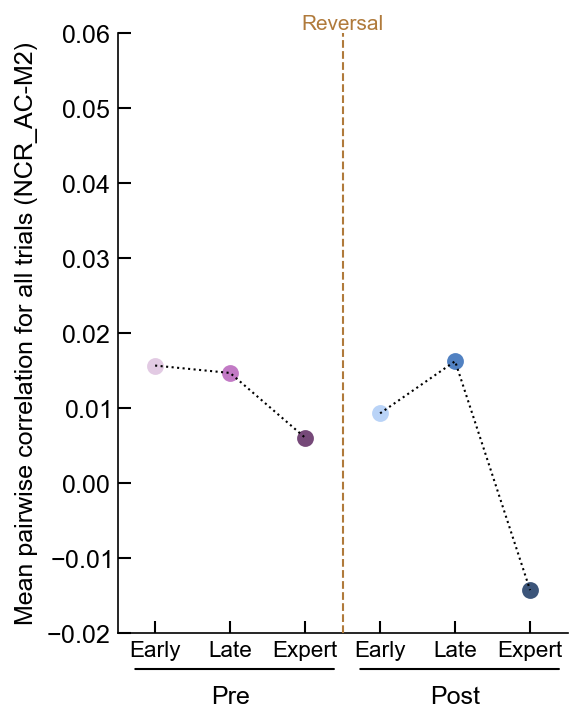

In [181]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr_NCR, mean_prelate_corr_NCR, mean_preexpert_corr_NCR, mean_postearly_corr_NCR, mean_postlate_corr_NCR, mean_postexpert_corr_NCR]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.02,0.06])
ylab = ax.set_ylabel('Mean pairwise correlation for all trials (NCR_AC-M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

#### Saving pickle files

In [182]:
#Create pickle file
AC_M2_pairwise_corr_all_NCR_AC_with_nan = SimpleNamespace(prereversal_early=preearly_corr_NCR,
                      prereversal_late=prelate_corr_NCR,
                      prereversal_expert=preexpert_corr_NCR,
                      postreversal_early=postearly_corr_NCR,
                      postreversal_late=postlate_corr_NCR,
                      postreversal_expert=postexpert_corr_NCR
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_all_NCR_AC_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_all_NCR_AC_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

#### Significance Test

In [183]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [184]:
AC_M2_pairwise_corr_all_NCR_AC_with_nan = SimpleNamespace(preearly=preearly_corr_NCR,
                      prelate=prelate_corr_NCR,
                      preexpert=preexpert_corr_NCR,
                      postearly=postearly_corr_NCR,
                      postlate=postlate_corr_NCR,
                      postexpert=postexpert_corr_NCR
                     )

pairwise_AC_NCR = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise_corr_all_NCR_AC_with_nan)

            Source          SS       DF        MS         F     p-unc  \
0            phase    0.153843      3.0  0.051281  4.687122  0.002832   
1          context    0.005398      1.0  0.005398  0.493413  0.482421   
2  phase * context    0.232983      3.0  0.077661  7.098288  0.000092   
3         Residual  149.429762  13658.0  0.010941       NaN       NaN   

        np2  
0  0.001028  
1  0.000036  
2  0.001557  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000044  0.000177  0.231428
8     post-late  baseline  experimental  0.004285  0.008570 -0.069202
9    pre-expert  baseline  experimental  0.117709  0.156946  0.093172
10     pre-late  baseline  experimental  0.443198  0.443198  0.008842


## ACC CR target and non-target trials

In [14]:
AC_sessions_M2intersect = list(AC_sessions)
M2_sessions_ACintersect = list(M2_sessions)

In [36]:
for recording in AC_preearly:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_preearly:
        AC_preearly.remove(recording)
        
for recording in AC_prelate:
    m2_name = recording.replace('AC', 'M2')
    h = m2_name in M2_prelate
    if m2_name not in M2_prelate:
        AC_prelate.remove(recording)
        
for recording in AC_preexpert:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_preexpert:
        AC_preexpert.remove(recording)
        
for recording in AC_postearly:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_postearly:
        AC_postearly.remove(recording)
        
for recording in AC_postlate:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_postlate:
        AC_postlate.remove(recording)
        
for recording in AC_postexpert:
    m2_name = recording.replace('AC', 'M2')
    if m2_name not in M2_postexpert:
        AC_postexpert.remove(recording)

In [202]:
def getPairsACM2_And_CRClustersPairs(AC_session):
    session_AC = ilep.loadSessionCached(act_directory,AC_session)
    m2_name = AC_session.replace('AC','M2')
    index_M2 = M2_sessions_ACintersect.index(m2_name)
    session_M2 = ilep.loadSessionCached(act_directory,M2_sessions_ACintersect[index_M2])
    clust_AC = []
    for clust in session_AC.clusters.good:
        if session_AC.responsiveness[clust]['target'].FRmodulation >= FRmod_baseline:
            clust_AC.append(clust)
    clust_M2 = session_M2.clusters.good
    cluster_pairs = list(product(clust_AC, clust_M2))
    return session_AC,session_M2, clust_AC, clust_M2, cluster_pairs

In [203]:
def getTrialstoUse(session_AC, session_M2, clustAC, clustM2):
    trials_AC = ilep.getAllConditions(session_AC,clustAC,trialsPerDayLoaded=None)['target']
    trials_M2 = ilep.getAllConditions(session_M2,clustM2,trialsPerDayLoaded=None)['target']
    trials_AC = trials_AC.trials
    trials_M2 = trials_M2.trials
    trials_to_use = np.intersect1d(trials_AC,trials_M2)
    return trials_to_use

In [204]:
def getResSpikeCounts(trials_to_use, session_AC,session_M2, clust_AC, clust_M2, window):
    start_trials = session_AC.trials.starts
    start_trials = [start_trials[trial_id] for trial_id in trials_to_use]
    spikeTimes_AC = [[]]
    spikeTimes_M2 = [[]]
    for trials in start_trials:
        end_time = trials + window*30000
        spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=clust_AC,starttime=trials,endtime=end_time,cachedtimes=None)
        spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=clust_M2,starttime=trials,endtime=end_time,cachedtimes=None)
        spikeTimes_AC.append(spikeTimes_1_AC)
        spikeTimes_M2.append(spikeTimes_1_M2)

    spikeCountsAC = []
    spikeCountsM2 = []
    spikeCountsAC = [len(row) for row in spikeTimes_AC]
    spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
    spikeCountsAC = np.array(spikeCountsAC)
    spikeCountsM2 = np.array(spikeCountsM2)
    mean_AC = np.mean(spikeCountsAC)
    mean_M2 = np.mean(spikeCountsM2)
    resSpikeCountAC = spikeCountsAC - mean_AC
    resSpikeCountM2 = spikeCountsM2 - mean_M2
    
    return resSpikeCountAC, resSpikeCountM2

In [205]:
def getACM2PearsonCorrelationCR(AC_session):
    correlation = []
    p_value = []
    session_AC, session_M2, clust_AC, clust_M2, cluster_pairs = getPairsACM2_And_CRClustersPairs(AC_session)
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        trials_to_use = getTrialstoUse(session_AC, session_M2, AC_clust, M2_clust)
        if len(trials_to_use) >= 100:
            resSpikeCountAC, resSpikeCountM2 = getResSpikeCounts(trials_to_use, session_AC, session_M2, AC_clust, M2_clust, 0.2)
            corr, p_val = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            p_value.append(p_val)

    return correlation, p_value

In [206]:
FRmod_baseline = 3.5533237685317998

### Target

In [41]:
preearly_corr_CR_target = []
for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelationCR(session)
    preearly_corr_CR_target.extend(correlation)

In [42]:
prelate_corr_CR_target = []
for session in AC_prelate:
    correlation_pl, p_val = getACM2PearsonCorrelationCR(session)
    prelate_corr_CR_target.extend(correlation_pl)

In [207]:
preexpert_corr_CR_target = []
for session in AC_preexpert:
    correlation_pe, p_val = getACM2PearsonCorrelationCR(session)
    preexpert_corr_CR_target.extend(correlation_pe)

In [44]:
postearly_corr_CR_target = []
for session in AC_postearly:
    correlation_poe, p_val = getACM2PearsonCorrelationCR(session)
    postearly_corr_CR_target.extend(correlation_poe)

In [45]:
postlate_corr_CR_target = []
for session in AC_postlate:
    correlation_pol, p_val = getACM2PearsonCorrelationCR(session)
    postlate_corr_CR_target.extend(correlation_pol)

In [46]:
postexpert_corr_CR_target = []
for session in AC_postexpert:
    correlation_poex, p_val = getACM2PearsonCorrelationCR(session)
    postexpert_corr_CR_target.extend(correlation_poex)

In [208]:
preearly_corr_CR_target = np.array(preearly_corr_CR_target)
prelate_corr_CR_target = np.array(prelate_corr_CR_target)
preexpert_corr_CR_target = np.array(preexpert_corr_CR_target)
postearly_corr_CR_target = np.array(postearly_corr_CR_target)
postlate_corr_CR_target = np.array(postlate_corr_CR_target)
postexpert_corr_CR_target = np.array(postexpert_corr_CR_target)


preearly_corr_CR_target = preearly_corr_CR_target[~np.isnan(preearly_corr_CR_target)]
prelate_corr_CR_target = prelate_corr_CR_target[~np.isnan(prelate_corr_CR_target)]
preexpert_corr_CR_target = preexpert_corr_CR_target[~np.isnan(preexpert_corr_CR_target)]
postearly_corr_CR_target = postearly_corr_CR_target[~np.isnan(postearly_corr_CR_target)]
postlate_corr_CR_target = postlate_corr_CR_target[~np.isnan(postlate_corr_CR_target)]
postexpert_corr_CR_target = postexpert_corr_CR_target[~np.isnan(postexpert_corr_CR_target)]

In [209]:
mean_preearly_corr_CR_target = np.mean(preearly_corr_CR_target)
std_preearly_corr_CR_target = np.std(preearly_corr_CR_target)

mean_prelate_corr_CR_target = np.mean(prelate_corr_CR_target)
std_prelate_corr_CR_target = np.std(prelate_corr_CR_target)

mean_preexpert_corr_CR_target = np.mean(preexpert_corr_CR_target)
std_preexpert_corr_CR_target = np.std(preexpert_corr_CR_target)

mean_postearly_corr_CR_target = np.mean(postearly_corr_CR_target)
std_postearly_corr_CR_target = np.std(postearly_corr_CR_target)

mean_postlate_corr_CR_target = np.mean(postlate_corr_CR_target)
std_postlate_corr_CR_target = np.std(postlate_corr_CR_target)

mean_postexpert_corr_CR_target = np.mean(postexpert_corr_CR_target)
std_postexpert_corr_CR_target = np.std(postexpert_corr_CR_target)

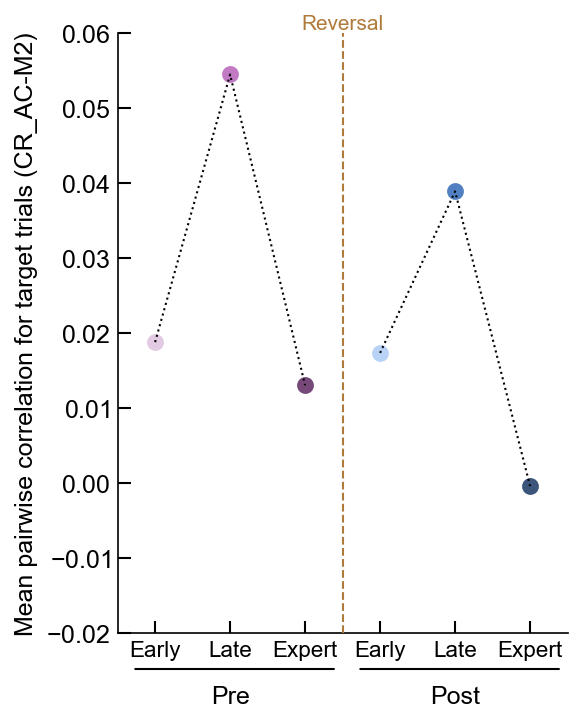

In [210]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr_CR_target, mean_prelate_corr_CR_target, mean_preexpert_corr_CR_target, mean_postearly_corr_CR_target, mean_postlate_corr_CR_target, mean_postexpert_corr_CR_target]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.02,0.06])
ylab = ax.set_ylabel('Mean pairwise correlation for target trials (CR_AC-M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

In [211]:
#Create pickle file
AC_M2_pairwise_corr_CR_AC_target_with_nan = SimpleNamespace(prereversal_early=preearly_corr_CR_target,
                      prereversal_late=prelate_corr_CR_target,
                      prereversal_expert=preexpert_corr_CR_target,
                      postreversal_early=postearly_corr_CR_target,
                      postreversal_late=postlate_corr_CR_target,
                      postreversal_expert=postexpert_corr_CR_target
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_corr_CR_AC_target_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_CR_AC_target_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

In [212]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [213]:
AC_M2_pairwise_corr_CR_AC_target_with_nan = SimpleNamespace(preearly=preearly_corr_CR_target,
                      prelate=prelate_corr_CR_target,
                      preexpert=preexpert_corr_CR_target,
                      postearly=postearly_corr_CR_target,
                      postlate=postlate_corr_CR_target,
                      postexpert=postexpert_corr_CR_target
                     )

pairwise_AC_CR_target = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise_corr_CR_AC_target_with_nan)

            Source          SS      DF        MS          F         p-unc  \
0            phase    0.165189     3.0  0.055063   3.018761  2.860681e-02   
1          context    0.605124     1.0  0.605124  33.175083  8.711640e-09   
2  phase * context    0.308899     3.0  0.102966   5.644997  7.342575e-04   
3         Residual  157.030832  8609.0  0.018240        NaN           NaN   

        np2  
0  0.001051  
1  0.003839  
2  0.001963  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  2.354136e-01  3.138848e-01  0.132924
8     post-late  baseline  experimental  4.611374e-05  9.222747e-05 -0.163843
9    pre-expert  baseline  experimental  6.046026e-01  6.046026e-01  0.044971
10     pre-late  baseline  experimental  1.407373e-07  5.629491e-07 -0.248016


In [141]:
pairwise_AC_CR_target

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,3508361.5,two-sided,1.110118e-01,1.665177e-01,fdr_bh,-0.039403
1,phase,-,post-expert,pre-expert,False,False,982458.0,two-sided,1.925838e-01,2.311005e-01,fdr_bh,-0.033799
2,phase,-,post-expert,pre-late,False,False,2465190.0,two-sided,4.541677e-10,2.725006e-09,fdr_bh,-0.183982
3,phase,-,post-late,pre-expert,False,False,1250706.0,two-sided,8.391767e-01,8.391767e-01,fdr_bh,0.005732
4,phase,-,post-late,pre-late,False,False,3137875.0,two-sided,3.614092e-07,1.084228e-06,fdr_bh,-0.148183
5,phase,-,pre-expert,pre-late,False,False,886560.0,two-sided,7.950429e-04,1.590086e-03,fdr_bh,-0.150272
6,context,-,baseline,experimental,False,False,6277938.0,two-sided,7.961527e-19,NaN,NaN,-0.225500
7,phase * context,post-expert,baseline,experimental,False,False,91030.0,two-sided,2.354136e-01,2.354136e-01,fdr_bh,0.132924
8,phase * context,post-late,baseline,experimental,False,False,681376.0,two-sided,4.611374e-05,9.222747e-05,fdr_bh,-0.163843
9,phase * context,pre-expert,baseline,experimental,False,False,22799.0,two-sided,4.732286e-02,6.309715e-02,fdr_bh,-0.237808


### Non-Target

In [63]:
preearly_corr_CR_nontarget = []
for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelationCR(session)
    preearly_corr_CR_nontarget.extend(correlation)

In [64]:
prelate_corr_CR_nontarget = []
for session in AC_prelate:
    correlation_pl, p_val = getACM2PearsonCorrelationCR(session)
    prelate_corr_CR_nontarget.extend(correlation_pl)

In [123]:
preexpert_corr_CR_nontarget = []
for session in AC_preexpert:
    correlation_pe, p_val = getACM2PearsonCorrelationCR(session)
    preexpert_corr_CR_nontarget.extend(correlation_pe)

In [66]:
postearly_corr_CR_nontarget = []
for session in AC_postearly:
    correlation_poe, p_val = getACM2PearsonCorrelationCR(session)
    postearly_corr_CR_nontarget.extend(correlation_poe)

In [67]:
postlate_corr_CR_nontarget = []
for session in AC_postlate:
    correlation_pol, p_val = getACM2PearsonCorrelationCR(session)
    postlate_corr_CR_nontarget.extend(correlation_pol)

In [68]:
postexpert_corr_CR_nontarget = []
for session in AC_postexpert:
    correlation_poex, p_val = getACM2PearsonCorrelationCR(session)
    postexpert_corr_CR_nontarget.extend(correlation_poex)

In [142]:
preearly_corr_CR_nontarget = np.array(preearly_corr_CR_nontarget)
prelate_corr_CR_nontarget = np.array(prelate_corr_CR_nontarget)
preexpert_corr_CR_nontarget = np.array(preexpert_corr_CR_nontarget)
postearly_corr_CR_nontarget = np.array(postearly_corr_CR_nontarget)
postlate_corr_CR_nontarget = np.array(postlate_corr_CR_nontarget)
postexpert_corr_CR_nontarget = np.array(postexpert_corr_CR_nontarget)


preearly_corr_CR_nontarget = preearly_corr_CR_nontarget[~np.isnan(preearly_corr_CR_nontarget)]
prelate_corr_CR_nontarget = prelate_corr_CR_nontarget[~np.isnan(prelate_corr_CR_nontarget)]
preexpert_corr_CR_nontarget = preexpert_corr_CR_nontarget[~np.isnan(preexpert_corr_CR_nontarget)]
postearly_corr_CR_nontarget = postearly_corr_CR_nontarget[~np.isnan(postearly_corr_CR_nontarget)]
postlate_corr_CR_nontarget = postlate_corr_CR_nontarget[~np.isnan(postlate_corr_CR_nontarget)]
postexpert_corr_CR_nontarget = postexpert_corr_CR_nontarget[~np.isnan(postexpert_corr_CR_nontarget)]

In [143]:
mean_preearly_corr_CR_nontarget = np.mean(preearly_corr_CR_nontarget)
std_preearly_corr_CR_nontarget = np.std(preearly_corr_CR_nontarget)

mean_prelate_corr_CR_nontarget = np.mean(prelate_corr_CR_nontarget)
std_prelate_corr_CR_nontarget = np.std(prelate_corr_CR_target)

mean_preexpert_corr_CR_nontarget = np.mean(preexpert_corr_CR_nontarget)
std_preexpert_corr_CR_nontarget = np.std(preexpert_corr_CR_nontarget)

mean_postearly_corr_CR_nontarget = np.mean(postearly_corr_CR_nontarget)
std_postearly_corr_CR_nontarget = np.std(postearly_corr_CR_nontarget)

mean_postlate_corr_CR_nontarget = np.mean(postlate_corr_CR_nontarget)
std_postlate_corr_CR_nontarget = np.std(postlate_corr_CR_nontarget)

mean_postexpert_corr_CR_nontarget = np.mean(postexpert_corr_CR_nontarget)
std_postexpert_corr_CR_nontarget = np.std(postexpert_corr_CR_nontarget)

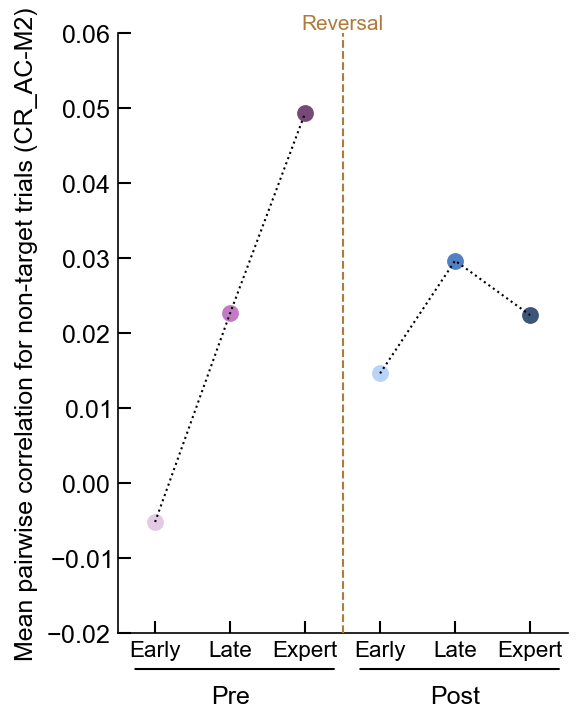

In [144]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr_CR_nontarget, mean_prelate_corr_CR_nontarget, mean_preexpert_corr_CR_nontarget, mean_postearly_corr_CR_nontarget, mean_postlate_corr_CR_nontarget, mean_postexpert_corr_CR_nontarget]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.02,0.06])
ylab = ax.set_ylabel('Mean pairwise correlation for non-target trials (CR_AC-M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

In [145]:
#Create pickle file
AC_M2_pairwise_corr_CR_AC_nontarget_with_nan = SimpleNamespace(prereversal_early=preearly_corr_CR_nontarget,
                      prereversal_late=prelate_corr_CR_nontarget,
                      prereversal_expert=preexpert_corr_CR_nontarget,
                      postreversal_early=postearly_corr_CR_nontarget,
                      postreversal_late=postlate_corr_CR_nontarget,
                      postreversal_expert=postexpert_corr_CR_nontarget
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_corr_CR_AC_nontarget_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_CR_AC_nontarget_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [146]:
AC_M2_pairwise_corr_CR_AC_nontarget_with_nan = SimpleNamespace(preearly=preearly_corr_CR_nontarget,
                      prelate=prelate_corr_CR_nontarget,
                      preexpert=preexpert_corr_CR_nontarget,
                      postearly=postearly_corr_CR_nontarget,
                      postlate=postlate_corr_CR_nontarget,
                      postexpert=postexpert_corr_CR_nontarget
                     )

pairwise_AC_CR_nontarget = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise_corr_CR_AC_nontarget_with_nan)

            Source          SS      DF        MS          F     p-unc  \
0            phase    0.145751     3.0  0.048584   2.680406  0.045238   
1          context    0.360778     1.0  0.360778  19.904484  0.000008   
2  phase * context    0.099968     3.0  0.033323   1.838436  0.137817   
3         Residual  147.559367  8141.0  0.018125        NaN       NaN   

        np2  
0  0.000987  
1  0.002439  
2  0.000677  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.892400  0.892400 -0.056153
8     post-late  baseline  experimental  0.001072  0.002956 -0.110187
9    pre-expert  baseline  experimental  0.001478  0.002956 -0.499511
10     pre-late  baseline  experimental  0.004195  0.005593 -0.219145


## ACC NCR target and non-target 

In [192]:
def getPairsACM2_And_NCRClustersPairs(AC_session):
    session_AC = ilep.loadSessionCached(act_directory,AC_session)
    m2_name = AC_session.replace('AC','M2')
    index_M2 = M2_sessions_ACintersect.index(m2_name)
    session_M2 = ilep.loadSessionCached(act_directory,M2_sessions_ACintersect[index_M2])
    clust_AC = []
    for clust in session_AC.clusters.good:
        if session_AC.responsiveness[clust]['target'].FRmodulation < FRmod_baseline:
            clust_AC.append(clust)
    clust_M2 = session_M2.clusters.good
    cluster_pairs = list(product(clust_AC, clust_M2))
    return session_AC,session_M2, clust_AC, clust_M2, cluster_pairs

In [193]:
def getTrialstoUse(session_AC, session_M2, clustAC, clustM2):
    trials_AC = ilep.getAllConditions(session_AC,clustAC,trialsPerDayLoaded=None)['target']
    trials_M2 = ilep.getAllConditions(session_M2,clustM2,trialsPerDayLoaded=None)['target']
    trials_AC = trials_AC.trials
    trials_M2 = trials_M2.trials
    trials_to_use = np.intersect1d(trials_AC,trials_M2)
    return trials_to_use

In [194]:
def getResSpikeCounts(trials_to_use, session_AC,session_M2, clust_AC, clust_M2, window):
    start_trials = session_AC.trials.starts
    start_trials = [start_trials[trial_id] for trial_id in trials_to_use]
    spikeTimes_AC = [[]]
    spikeTimes_M2 = [[]]
    for trials in start_trials:
        end_time = trials + window*30000
        spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=clust_AC,starttime=trials,endtime=end_time,cachedtimes=None)
        spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=clust_M2,starttime=trials,endtime=end_time,cachedtimes=None)
        spikeTimes_AC.append(spikeTimes_1_AC)
        spikeTimes_M2.append(spikeTimes_1_M2)

    spikeCountsAC = []
    spikeCountsM2 = []
    spikeCountsAC = [len(row) for row in spikeTimes_AC]
    spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
    spikeCountsAC = np.array(spikeCountsAC)
    spikeCountsM2 = np.array(spikeCountsM2)
    mean_AC = np.mean(spikeCountsAC)
    mean_M2 = np.mean(spikeCountsM2)
    resSpikeCountAC = spikeCountsAC - mean_AC
    resSpikeCountM2 = spikeCountsM2 - mean_M2
    
    return resSpikeCountAC, resSpikeCountM2

In [195]:
def getACM2PearsonCorrelationNCR(AC_session):
    correlation = []
    p_value = []
    session_AC, session_M2, clust_AC, clust_M2, cluster_pairs = getPairsACM2_And_NCRClustersPairs(AC_session)
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        trials_to_use = getTrialstoUse(session_AC, session_M2, AC_clust, M2_clust)
        if len(trials_to_use) >= 100:
            resSpikeCountAC, resSpikeCountM2 = getResSpikeCounts(trials_to_use, session_AC, session_M2, AC_clust, M2_clust, 0.2)
            corr, p_val = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            p_value.append(p_val)

    return correlation, p_value

### Target

In [86]:
preearly_corr_NCR_target = []
for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelationNCR(session)
    preearly_corr_NCR_target.extend(correlation)

In [87]:
prelate_corr_NCR_target = []
for session in AC_prelate:
    correlation_pl, p_val = getACM2PearsonCorrelationNCR(session)
    prelate_corr_NCR_target.extend(correlation_pl)

In [196]:
preexpert_corr_NCR_target = []
for session in AC_preexpert:
    correlation_pe, p_val = getACM2PearsonCorrelationNCR(session)
    preexpert_corr_NCR_target.extend(correlation_pe)

In [89]:
postearly_corr_NCR_target = []
for session in AC_postearly:
    correlation_poe, p_val = getACM2PearsonCorrelationNCR(session)
    postearly_corr_NCR_target.extend(correlation_poe)

/Users/insanallylab/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [90]:
postlate_corr_NCR_target = []
for session in AC_postlate:
    correlation_pol, p_val = getACM2PearsonCorrelationNCR(session)
    postlate_corr_NCR_target.extend(correlation_pol)

In [91]:
postexpert_corr_NCR_target = []
for session in AC_postexpert:
    correlation_poex, p_val = getACM2PearsonCorrelationNCR(session)
    postexpert_corr_NCR_target.extend(correlation_poex)

In [197]:
preearly_corr_NCR_target = np.array(preearly_corr_NCR_target)
prelate_corr_NCR_target = np.array(prelate_corr_NCR_target)
preexpert_corr_NCR_target = np.array(preexpert_corr_NCR_target)
postearly_corr_NCR_target = np.array(postearly_corr_NCR_target)
postlate_corr_NCR_target = np.array(postlate_corr_NCR_target)
postexpert_corr_NCR_target = np.array(postexpert_corr_NCR_target)


preearly_corr_NCR_target = preearly_corr_NCR_target[~np.isnan(preearly_corr_NCR_target)]
prelate_corr_NCR_target = prelate_corr_NCR_target[~np.isnan(prelate_corr_NCR_target)]
preexpert_corr_NCR_target = preexpert_corr_NCR_target[~np.isnan(preexpert_corr_NCR_target)]
postearly_corr_NCR_target = postearly_corr_NCR_target[~np.isnan(postearly_corr_NCR_target)]
postlate_corr_NCR_target = postlate_corr_NCR_target[~np.isnan(postlate_corr_NCR_target)]
postexpert_corr_NCR_target = postexpert_corr_NCR_target[~np.isnan(postexpert_corr_NCR_target)]

In [198]:
mean_preearly_corr_NCR_target = np.mean(preearly_corr_NCR_target)
std_preearly_corr_NCR_target = np.std(preearly_corr_NCR_target)

mean_prelate_corr_NCR_target = np.mean(prelate_corr_NCR_target)
std_prelate_corr_NCR_target = np.std(prelate_corr_NCR_target)

mean_preexpert_corr_NCR_target = np.mean(preexpert_corr_NCR_target)
std_preexpert_corr_NCR_target = np.std(preexpert_corr_NCR_target)

mean_postearly_corr_NCR_target = np.mean(postearly_corr_NCR_target)
std_postearly_corr_NCR_target = np.std(postearly_corr_NCR_target)

mean_postlate_corr_NCR_target = np.mean(postlate_corr_NCR_target)
std_postlate_corr_NCR_target = np.std(postlate_corr_NCR_target)

mean_postexpert_corr_NCR_target = np.mean(postexpert_corr_NCR_target)
std_postexpert_corr_NCR_target = np.std(postexpert_corr_NCR_target)

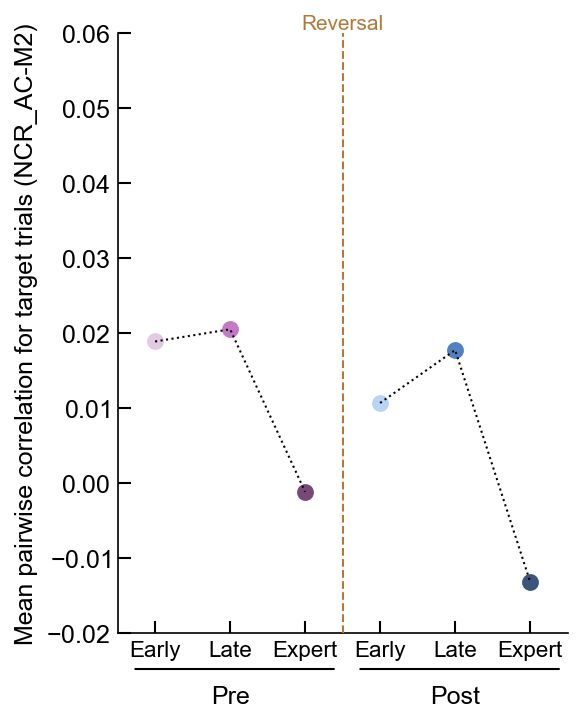

In [199]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr_NCR_target, mean_prelate_corr_NCR_target, mean_preexpert_corr_NCR_target, mean_postearly_corr_NCR_target, mean_postlate_corr_NCR_target, mean_postexpert_corr_NCR_target]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.02,0.06])
ylab = ax.set_ylabel('Mean pairwise correlation for target trials (NCR_AC-M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

In [200]:
#Create pickle file
AC_M2_pairwise_corr_NCR_AC_target_with_nan = SimpleNamespace(prereversal_early=preearly_corr_NCR_target,
                      prereversal_late=prelate_corr_NCR_target,
                      prereversal_expert=preexpert_corr_NCR_target,
                      postreversal_early=postearly_corr_NCR_target,
                      postreversal_late=postlate_corr_NCR_target,
                      postreversal_expert=postexpert_corr_NCR_target
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_corr_NCR_AC_target_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_NCR_AC_target_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

In [201]:
AC_M2_pairwise_corr_NCR_AC_target_with_nan = SimpleNamespace(preearly=preearly_corr_NCR_target,
                      prelate=prelate_corr_NCR_target,
                      preexpert=preexpert_corr_NCR_target,
                      postearly=postearly_corr_NCR_target,
                      postlate=postlate_corr_NCR_target,
                      postexpert=postexpert_corr_NCR_target
                     )

pairwise_AC_NCR_target = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise_corr_NCR_AC_target_with_nan)

            Source          SS      DF        MS         F     p-unc       np2
0            phase    0.134214     3.0  0.044738  3.809540  0.009647  0.001153
1          context    0.000411     1.0  0.000411  0.034992  0.851615  0.000004
2  phase * context    0.185276     3.0  0.061759  5.258885  0.001267  0.001591
3         Residual  116.297572  9903.0  0.011744       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.002611  0.010445  0.225474
8     post-late  baseline  experimental  0.015472  0.030945 -0.065884
9    pre-expert  baseline  experimental  0.101010  0.134679  0.176184
10     pre-late  baseline  experimental  0.991834  0.991834 -0.014425


### Non-Target

In [101]:
preearly_corr_NCR_nontarget = []
for session in AC_preearly:
    correlation, p_val = getACM2PearsonCorrelationNCR(session)
    preearly_corr_NCR_nontarget.extend(correlation)

In [102]:
prelate_corr_NCR_nontarget = []
for session in AC_prelate:
    correlation_pl, p_val = getACM2PearsonCorrelationNCR(session)
    prelate_corr_NCR_nontarget.extend(correlation_pl)

In [120]:
preexpert_corr_NCR_nontarget = []
for session in AC_preexpert:
    correlation_pe, p_val = getACM2PearsonCorrelationNCR(session)
    preexpert_corr_NCR_nontarget.extend(correlation_pe)

In [104]:
postearly_corr_NCR_nontarget = []
for session in AC_postearly:
    correlation_poe, p_val = getACM2PearsonCorrelationNCR(session)
    postearly_corr_NCR_nontarget.extend(correlation_poe)

/Users/insanallylab/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [105]:
postlate_corr_NCR_nontarget = []
for session in AC_postlate:
    correlation_pol, p_val = getACM2PearsonCorrelationNCR(session)
    postlate_corr_NCR_nontarget.extend(correlation_pol)

In [106]:
postexpert_corr_NCR_nontarget = []
for session in AC_postexpert:
    correlation_poex, p_val = getACM2PearsonCorrelationNCR(session)
    postexpert_corr_NCR_nontarget.extend(correlation_poex)

In [152]:
preearly_corr_NCR_nontarget = np.array(preearly_corr_NCR_nontarget)
prelate_corr_NCR_nontarget = np.array(prelate_corr_NCR_nontarget)
preexpert_corr_NCR_nontarget = np.array(preexpert_corr_NCR_nontarget)
postearly_corr_NCR_nontarget = np.array(postearly_corr_NCR_nontarget)
postlate_corr_NCR_nontarget = np.array(postlate_corr_NCR_nontarget)
postexpert_corr_NCR_nontarget = np.array(postexpert_corr_NCR_nontarget)


preearly_corr_NCR_nontarget = preearly_corr_NCR_nontarget[~np.isnan(preearly_corr_NCR_nontarget)]
prelate_corr_NCR_nontarget = prelate_corr_NCR_nontarget[~np.isnan(prelate_corr_NCR_nontarget)]
preexpert_corr_NCR_nontarget = preexpert_corr_NCR_nontarget[~np.isnan(preexpert_corr_NCR_nontarget)]
postearly_corr_NCR_nontarget = postearly_corr_NCR_nontarget[~np.isnan(postearly_corr_NCR_nontarget)]
postlate_corr_NCR_nontarget = postlate_corr_NCR_nontarget[~np.isnan(postlate_corr_NCR_nontarget)]
postexpert_corr_NCR_nontarget = postexpert_corr_NCR_nontarget[~np.isnan(postexpert_corr_NCR_nontarget)]

In [153]:
mean_preearly_corr_NCR_nontarget = np.mean(preearly_corr_NCR_nontarget)
std_preearly_corr_NCR_nontarget = np.std(preearly_corr_NCR_nontarget)

mean_prelate_corr_NCR_nontarget = np.mean(prelate_corr_NCR_nontarget)
std_prelate_corr_NCR_nontarget = np.std(prelate_corr_NCR_nontarget)

mean_preexpert_corr_NCR_nontarget = np.mean(preexpert_corr_NCR_nontarget)
std_preexpert_corr_NCR_nontarget = np.std(preexpert_corr_NCR_nontarget)

mean_postearly_corr_NCR_nontarget = np.mean(postearly_corr_NCR_nontarget)
std_postearly_corr_NCR_nontarget = np.std(postearly_corr_NCR_nontarget)

mean_postlate_corr_NCR_nontarget = np.mean(postlate_corr_NCR_nontarget)
std_postlate_corr_NCR_nontarget = np.std(postlate_corr_NCR_nontarget)

mean_postexpert_corr_NCR_nontarget = np.mean(postexpert_corr_NCR_nontarget)
std_postexpert_corr_NCR_nontarget = np.std(postexpert_corr_NCR_nontarget)

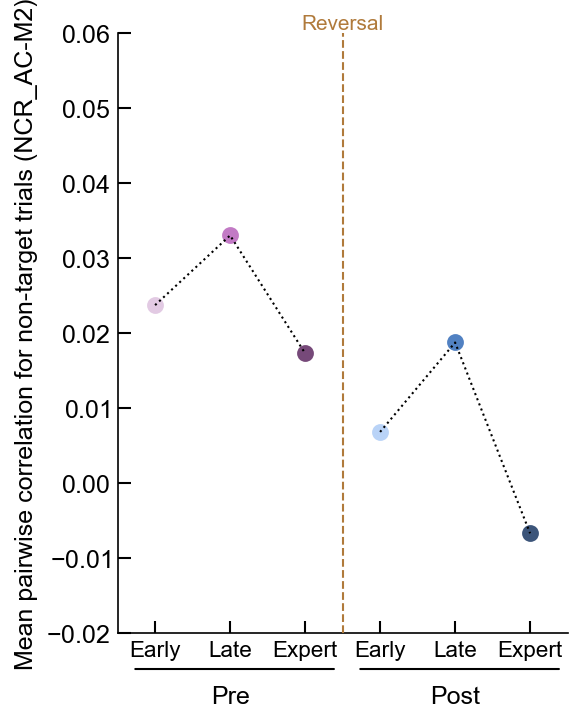

In [154]:
stdfont = 12
stdyfrac = 0.06
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax
def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax
fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
################################################################################################################
#Plot figure
data = [mean_preearly_corr_NCR_nontarget, mean_prelate_corr_NCR_nontarget, mean_preexpert_corr_NCR_nontarget, mean_postearly_corr_NCR_nontarget, mean_postlate_corr_NCR_nontarget, mean_postexpert_corr_NCR_nontarget]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
for idx,column in enumerate(data):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],data[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],data[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']
ax.set_ylim([-0.02,0.06])
ylab = ax.set_ylabel('Mean pairwise correlation for non-target trials (NCR_AC-M2)')
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.tick_params(direction='in', length=6, width=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1,t2]
ax.ticklabel_format(style='plain', useOffset=False, axis='y')

In [155]:
#Saving pickle files
AC_M2_pairwise_corr_NCR_AC_nontarget_with_nan = SimpleNamespace(prereversal_early=preearly_corr_NCR_nontarget,
                      prereversal_late=prelate_corr_NCR_nontarget,
                      prereversal_expert=preexpert_corr_NCR_nontarget,
                      postreversal_early=postearly_corr_NCR_nontarget,
                      postreversal_late=postlate_corr_NCR_nontarget,
                      postreversal_expert=postexpert_corr_NCR_nontarget
                     )

#Save to pickle
filename = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/AC_M2_pairwise_corr_NCR_AC_nontarget_with_nan.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_M2_pairwise_corr_NCR_AC_nontarget_with_nan, f, protocol=pickle.HIGHEST_PROTOCOL)

In [156]:
AC_M2_pairwise_corr_NCR_AC_nontarget_with_nan = SimpleNamespace(preearly=preearly_corr_NCR_nontarget,
                      prelate=prelate_corr_NCR_nontarget,
                      preexpert=preexpert_corr_NCR_nontarget,
                      postearly=postearly_corr_NCR_nontarget,
                      postlate=postlate_corr_NCR_nontarget,
                      postexpert=postexpert_corr_NCR_nontarget
                     )

pairwise_AC_NCR_nontarget = ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_M2_pairwise_corr_NCR_AC_nontarget_with_nan)

            Source          SS      DF        MS          F         p-unc  \
0            phase    0.691690     3.0  0.230563  16.116795  1.900592e-10   
1          context    0.067960     1.0  0.067960   4.750531  2.931338e-02   
2  phase * context    0.138647     3.0  0.046216   3.230559  2.141994e-02   
3         Residual  137.936417  9642.0  0.014306        NaN           NaN   

        np2  
0  0.004990  
1  0.000492  
2  0.001004  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.130609  0.174146  0.113790
8     post-late  baseline  experimental  0.000750  0.003001 -0.101327
9    pre-expert  baseline  experimental  0.207444  0.207444  0.054192
10     pre-late  baseline  experimental  0.118368  0.174146 -0.075541


In [222]:
len(postexpert_corr_CR_nontarget)

52

# Correlation Sense

In [103]:
## Trying to make sense of correlations
print(type(AC_sessions))


session_AC = ilep.loadSessionCached(act_directory,AC_sessions[11])
name_AC = AC_sessions[8]
m2_name = name_AC.replace('AC','M2')
indexM2 = M2_sessions.index(m2_name)                       
session_M2 = ilep.loadSessionCached(act_directory,M2_sessions[indexM2])
clust_AC = session_AC.clusters.good
clust_M2 = session_M2.clusters.good

<class 'list'>


In [118]:
type(clust_AC)

trials_AC = ilep.getAllConditions(session_AC,clust_AC[0],trialsPerDayLoaded=None)['nontarget']
trials_M2 = ilep.getAllConditions(session_M2,clust_M2[0],trialsPerDayLoaded=None)['nontarget']
trials_AC = trials_AC.trials
trials_M2 = trials_M2.trials
trials_to_use = np.intersect1d(trials_AC,trials_M2)

In [119]:
len(trials_to_use)

75

In [120]:
start_trials = session_AC.trials.starts
start_trials1 = [start_trials[trial_id] for trial_id in trials_to_use]
print(len(start_trials))
print(len(start_trials1))

485
75


In [121]:
spikeTimes_AC = [[]]
spikeTimes_M2 = [[]]
for trials in start_trials1:
    end_time = trials + 0.2*30000
    spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=clust_AC[0],starttime=trials,endtime=end_time,cachedtimes=None)
    spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=clust_M2[0],starttime=trials,endtime=end_time,cachedtimes=None)
    spikeTimes_AC.append(spikeTimes_1_AC)
    spikeTimes_M2.append(spikeTimes_1_M2)
    
    
spikeCountsAC = []
spikeCountsM2 = []
spikeCountsAC = [len(row) for row in spikeTimes_AC]
spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
spikeCountsAC = np.array(spikeCountsAC)
spikeCountsM2 = np.array(spikeCountsM2)
mean_AC = np.mean(spikeCountsAC)
mean_M2 = np.mean(spikeCountsM2)
resSpikeCountAC = spikeCountsAC - mean_AC
resSpikeCountM2 = spikeCountsM2 - mean_M2

In [122]:
corr, p_val = pearsonr(resSpikeCountAC, resSpikeCountM2)

In [123]:
corr

0.22215187381728843

## Recording

In [159]:
session_AC = ilep.loadSessionCached(act_directory,AC_sessions[8])
name_AC = AC_sessions[8]
m2_name = name_AC.replace('AC','M2')
indexM2 = M2_sessions.index(m2_name)                       
session_M2 = ilep.loadSessionCached(act_directory,M2_sessions[indexM2])
clust_AC = session_AC.clusters.good
clust_M2 = session_M2.clusters.good
cluster_pairs = list(product(clust_AC, clust_M2))
print(len(cluster_pairs))

192


In [1]:
correlation = []
pvalue = []
for pair in cluster_pairs:
    AC_clust, M2_clust = pair
    spikeTimes_AC = [[]]
    spikeTimes_M2 = [[]]
    
    trials_AC = ilep.getAllConditions(session_AC,AC_clust,trialsPerDayLoaded=None)['nontarget']
    trials_M2 = ilep.getAllConditions(session_M2,M2_clust,trialsPerDayLoaded=None)['nontarget']
    trials_AC = trials_AC.trials
    trials_M2 = trials_M2.trials
    
    trials_to_use = np.intersect1d(trials_AC,trials_M2)
    start_trials = session_AC.trials.starts
    start_trials1 = [start_trials[trial_id] for trial_id in trials_to_use]
    
    if len(start_trials1)>100:
        for trials in start_trials1:
            end_time = trials + 0.2*30000
            spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=AC_clust,starttime=trials,endtime=end_time,cachedtimes=None)
            spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=M2_clust,starttime=trials,endtime=end_time,cachedtimes=None)
            spikeTimes_AC.append(spikeTimes_1_AC)
            spikeTimes_M2.append(spikeTimes_1_M2)
    
        spikeCountsAC = []
        spikeCountsM2 = []
        spikeCountsAC = [len(row) for row in spikeTimes_AC]
        spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
        spikeCountsAC = np.array(spikeCountsAC)
        spikeCountsM2 = np.array(spikeCountsM2)
        mean_AC = np.mean(spikeCountsAC)
        mean_M2 = np.mean(spikeCountsM2)
        resSpikeCountAC = spikeCountsAC - mean_AC
        resSpikeCountM2 = spikeCountsM2 - mean_M2
        corr,pval = pearsonr(resSpikeCountAC, resSpikeCountM2)
        correlation.append(corr)
        pvalue.append(pval)

NameError: name 'cluster_pairs' is not defined

In [165]:
correlation = np.array(correlation)
corr_rec = np.mean(correlation)
print(corr_rec)

0.008242686098065262


In [20]:
M2_sessions = list(M2_sessions)

preearly_corr = []
preearly_pval = []
for session in AC_preearly:
    session_AC = ilep.loadSessionCached(act_directory,session)
    name_AC = session
    m2_name = name_AC.replace('AC','M2')
    indexM2 = M2_sessions.index(m2_name)                       
    session_M2 = ilep.loadSessionCached(act_directory,M2_sessions[indexM2])
    clust_AC = session_AC.clusters.good
    clust_M2 = session_M2.clusters.good
    cluster_pairs = list(product(clust_AC, clust_M2))
    print(len(cluster_pairs))
    correlation = []
    pvalue = []
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        spikeTimes_AC = [[]]
        spikeTimes_M2 = [[]]
    
        trials_AC = ilep.getAllConditions(session_AC,AC_clust,trialsPerDayLoaded=None)['all_trials']
        trials_M2 = ilep.getAllConditions(session_M2,M2_clust,trialsPerDayLoaded=None)['all_trials']
        trials_AC = trials_AC.trials
        trials_M2 = trials_M2.trials
    
        trials_to_use = np.intersect1d(trials_AC,trials_M2)
        start_trials = session_AC.trials.starts
        start_trials1 = [start_trials[trial_id] for trial_id in trials_to_use]
    
        if len(start_trials1)>100:
            for trials in start_trials1:
                end_time = trials + 0.2*30000
                spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=AC_clust,starttime=trials,endtime=end_time,cachedtimes=None)
                spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=M2_clust,starttime=trials,endtime=end_time,cachedtimes=None)
                spikeTimes_AC.append(spikeTimes_1_AC)
                spikeTimes_M2.append(spikeTimes_1_M2)
    
            spikeCountsAC = []
            spikeCountsM2 = []
            spikeCountsAC = [len(row) for row in spikeTimes_AC]
            spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
            spikeCountsAC = np.array(spikeCountsAC)
            spikeCountsM2 = np.array(spikeCountsM2)
            mean_AC = np.mean(spikeCountsAC)
            mean_M2 = np.mean(spikeCountsM2)
            resSpikeCountAC = spikeCountsAC - mean_AC
            resSpikeCountM2 = spikeCountsM2 - mean_M2
            corr,pval = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            pvalue.append(pval)
    preearly_corr.extend(correlation)
    print(pvalue)

1612
session BS_49_1_AC_8-31-2021 clust 0 tried to load saved active trials but failed. Error: cannot access local variable 'trimmed_trials_active' where it is not associated with a value


UnboundLocalError: cannot access local variable 'trimmed_trials_active' where it is not associated with a value

In [178]:
preearly_corr = np.array(preearly_corr)
preearly_corr = preearly_corr[~np.isnan(preearly_corr)]
mean_preearly_corr = np.mean(preearly_corr)
print(mean_preearly_corr)

0.02177160789666788


In [184]:
preearly_corr_tar = []
for session in AC_preearly:
    session_AC = ilep.loadSessionCached(act_directory,session)
    name_AC = session
    m2_name = name_AC.replace('AC','M2')
    indexM2 = M2_sessions.index(m2_name)                       
    session_M2 = ilep.loadSessionCached(act_directory,M2_sessions[indexM2])
    clust_AC = session_AC.clusters.good
    clust_M2 = session_M2.clusters.good
    cluster_pairs = list(product(clust_AC, clust_M2))
    print(len(cluster_pairs))
    correlation = []
    pvalue = []
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        spikeTimes_AC = [[]]
        spikeTimes_M2 = [[]]
    
        trials_AC = ilep.getAllConditions(session_AC,AC_clust,trialsPerDayLoaded=None)['target']
        trials_M2 = ilep.getAllConditions(session_M2,M2_clust,trialsPerDayLoaded=None)['target']
        trials_AC = trials_AC.trials
        trials_M2 = trials_M2.trials
    
        trials_to_use = np.intersect1d(trials_AC,trials_M2)
        start_trials = session_AC.trials.starts
        start_trials1 = [start_trials[trial_id] for trial_id in trials_to_use]
    
        if len(start_trials1)>100:
            for trials in start_trials1:
                end_time = trials + 0.2*30000
                spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=AC_clust,starttime=trials,endtime=end_time,cachedtimes=None)
                spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=M2_clust,starttime=trials,endtime=end_time,cachedtimes=None)
                spikeTimes_AC.append(spikeTimes_1_AC)
                spikeTimes_M2.append(spikeTimes_1_M2)
    
            spikeCountsAC = []
            spikeCountsM2 = []
            spikeCountsAC = [len(row) for row in spikeTimes_AC]
            spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
            spikeCountsAC = np.array(spikeCountsAC)
            spikeCountsM2 = np.array(spikeCountsM2)
            mean_AC = np.mean(spikeCountsAC)
            mean_M2 = np.mean(spikeCountsM2)
            resSpikeCountAC = spikeCountsAC - mean_AC
            resSpikeCountM2 = spikeCountsM2 - mean_M2
            corr,pval = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            pvalue.append(pval)
    preearly_corr_tar.extend(correlation)

1612
527
486
85
693
180


In [181]:
preearly_corr_tar = np.array(preearly_corr_tar)
preearly_corr_tar = preearly_corr_tar[~np.isnan(preearly_corr_tar)]
mean_preearly_corr_tar = np.mean(preearly_corr_tar)
print(mean_preearly_corr_tar)

0.019655740736080278


In [182]:
preearly_corr_nontar = []
for session in AC_preearly:
    session_AC = ilep.loadSessionCached(act_directory,session)
    name_AC = session
    m2_name = name_AC.replace('AC','M2')
    indexM2 = M2_sessions.index(m2_name)                       
    session_M2 = ilep.loadSessionCached(act_directory,M2_sessions[indexM2])
    clust_AC = session_AC.clusters.good
    clust_M2 = session_M2.clusters.good
    cluster_pairs = list(product(clust_AC, clust_M2))
    print(len(cluster_pairs))
    correlation = []
    pvalue = []
    for pair in cluster_pairs:
        AC_clust, M2_clust = pair
        spikeTimes_AC = [[]]
        spikeTimes_M2 = [[]]
    
        trials_AC = ilep.getAllConditions(session_AC,AC_clust,trialsPerDayLoaded=None)['nontarget']
        trials_M2 = ilep.getAllConditions(session_M2,M2_clust,trialsPerDayLoaded=None)['nontarget']
        trials_AC = trials_AC.trials
        trials_M2 = trials_M2.trials
    
        trials_to_use = np.intersect1d(trials_AC,trials_M2)
        start_trials = session_AC.trials.starts
        start_trials1 = [start_trials[trial_id] for trial_id in trials_to_use]
    
        if len(start_trials1)>100:
            for trials in start_trials1:
                end_time = trials + 0.2*30000
                spikeTimes_1_AC = ilep.getSpikeTimes(session_AC,clust=AC_clust,starttime=trials,endtime=end_time,cachedtimes=None)
                spikeTimes_1_M2 = ilep.getSpikeTimes(session_M2,clust=M2_clust,starttime=trials,endtime=end_time,cachedtimes=None)
                spikeTimes_AC.append(spikeTimes_1_AC)
                spikeTimes_M2.append(spikeTimes_1_M2)
    
            spikeCountsAC = []
            spikeCountsM2 = []
            spikeCountsAC = [len(row) for row in spikeTimes_AC]
            spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
            spikeCountsAC = np.array(spikeCountsAC)
            spikeCountsM2 = np.array(spikeCountsM2)
            mean_AC = np.mean(spikeCountsAC)
            mean_M2 = np.mean(spikeCountsM2)
            resSpikeCountAC = spikeCountsAC - mean_AC
            resSpikeCountM2 = spikeCountsM2 - mean_M2
            corr,pval = pearsonr(resSpikeCountAC, resSpikeCountM2)
            correlation.append(corr)
            pvalue.append(pval)
    preearly_corr_nontar.extend(correlation)

1612
527
486
85
693
180


In [183]:
preearly_corr_nontar = np.array(preearly_corr_nontar)
preearly_corr_nontar = preearly_corr_nontar[~np.isnan(preearly_corr_nontar)]
mean_preearly_corr_nontar = np.mean(preearly_corr_nontar)
print(mean_preearly_corr_nontar)

0.018189587664884873


In [ ]:
# random

In [99]:
from random import randint

randomlist1 = []
randomlist2 = [] 
for i in range(0,100):
    n = randint(1,15)
    m = randint(1,15)
    randomlist1.append(n)
    randomlist2.append(m)

In [100]:
list1 = np.array(randomlist1)
list2 = np.array(randomlist2)

mean_1 = np.mean(list1)
mean_2 = np.mean(list2)
res_list1 = list1 - mean_1
res_list2 = list2 - mean_2

corr_ran, pval = pearsonr(res_list1, res_list2)
corr_ran

-0.29477103709682817

In [101]:
list_list1 = list1[:50]
list_list2 = list2[:50]
mean1_1 = np.mean(list_list1)
mean2_2 = np.mean(list_list2)
res_list_list1 = list_list1 - mean1_1
res_list_list2 = list_list2 - mean2_2

corr_ran1, pval1 = pearsonr(res_list_list1, res_list_list2)
corr_ran1

-0.19084513934428554

In [102]:
list1_list1 = list1[50:]
list2_list2 = list2[50:]
mean11_1 = np.mean(list1_list1)
mean22_2 = np.mean(list2_list2)
res_list1_list1 = list1_list1 - mean11_1
res_list2_list2 = list2_list2 - mean22_2

corr_ran11, pval2 = pearsonr(res_list1_list1, res_list2_list2)
corr_ran11

-0.41372600220661226

In [9]:
[k for k in animalBehaviors['BS_50'].sessions]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [11]:
animalBehaviors['BS_50'].reversal

inf

In [12]:
animalBehaviors['BS_50'].sessions[12]

namespace(animal='BS_50',
          session=12,
          files=array(['BS_50_12v1_reversal.txt', 'BS_50_12v1.txt',
                       'BS_50_12v3_reversal.txt', 'BS_50_12v4_reversal.txt'], dtype='<U23'),
          blocknumbers=array([1, 1, 3, 4]),
          type='switch',
          trials_per_session=array([ 29., 200.,  29.,  82.]),
          outcomes=0     1
                   1     1
                   2     1
                   3     1
                   4     2
                        ..
                   77    2
                   78    2
                   79    4
                   80    2
                   81    2
                   Name: outcome, Length: 340, dtype: int64,
          response_time=0     0.45717
                        1     0.31026
                        2     0.98948
                        3     0.31212
                        4     2.50150
                               ...   
                        77    2.50030
                        78    2.5003

In [ ]:
# Function to obtain pairs of AC and M2 sessions and cluster

def getPairsACM2_AndClustersPairs(AC_session):
    session_AC = ilep.loadSessionCached(act_directory,AC_session)
    m2_name = AC_session.replace('AC','M2')
    if m2_name not in EnumM2Session:
        continue
    else: 
        index_M2 = EnumM2Session.index(m2_name)
        session_M2 = ilep.loadSessionCached(act_directory,EnumM2Session[index_M2])
        clust_AC = session_AC.clusters.good
        clust_M2 = session_M2.clusters.good
        cluster_pairs = list(product(clust_AC, clust_M2))
    return session_AC,session_M2, clust_AC, clust_M2, cluster_pairs